In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_GPU import ZSTL
import pandas as pd
import itertools
import timeit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls ./drive/'My Drive'/'thesis_data'/'cub'/
!cp ./drive/'My Drive'/'thesis_data'/'cub'/'task_train_data_normalize.pickle' ./

task_train_data_normalize.pickle  task_train_data_standard.pickle
task_train_data.pickle


In [ ]:
net = FuncRecursiveNet([
    FLinearLayer(1, True)
])
shape_record = {0: [(1, 2049)]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
kb_size = 10
train_size = 140

In [ ]:

filename = './task_train_data_normalize.pickle'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
print(len(dataset), len(list(dataset.keys())))
print(type(dataset))

total_len = len(dataset)
test_size = total_len - kb_size - train_size


200 200
<class 'dict'>


In [ ]:
#np.random.seed(666)
indx = [ x+1 for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)
print('sum ',torch.sum(support_a, dim=0))

train_a, train_w, train_x, train_y = next(iter(train_loader))
print(train_a.shape)


10
140
50
312
2049
sum  tensor([38.0951, 37.0689, 36.8901, 35.4331, 40.5907, 34.0227, 32.5036, 31.7513,
        34.4475, 33.2477])
torch.Size([140, 1, 312])


test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.5180000000000002; align loss 17.438364028930664
1/5000 o_loss 0.7082201785474483; m train metric 0.5132142857142857; m test metric 0.5135000000000001; align loss  0.020893096923828125
200/5000 o_loss 0.6468857960642448; m train metric 0.6775892857142858; m test metric 0.627; align loss  0.015545845031738281
400/5000 o_loss 0.6337272650595488; m train metric 0.6944642857142858; m test metric 0.6247499999999999; align loss  0.01236724853515625
600/5000 o_loss 0.6189922196258392; m train metric 0.7097321428571428; m test metric 0.6337500000000001; align loss  0.010151863098144531
800/5000 o_loss 0.603571049616273; m train metric 0.7216964285714284; m test metric 0.6397499999999998; align loss  0.00863504409790039
1000/5000 o_loss 0.5882314466339137; m train metric 0.7324107142857149; m test metric 0.65475; align loss  0.00776910781

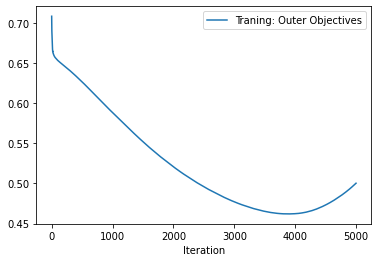

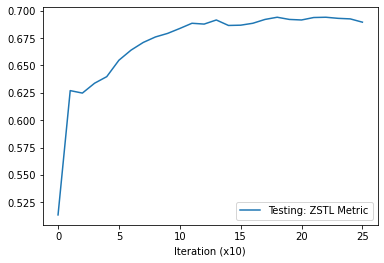

Time: 343.3531387680014


In [ ]:


param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 0.1
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 5e-4
param_dict['align lr'] = 5e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'

start = timeit.default_timer()
ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=5000)
stop = timeit.default_timer()
print('Time:', stop - start)

20
120
120
20
num of hp  36
rho for w_kb 1; mu for a_kb 1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 165.9906463623047
1/1800 o_loss 161.5289858778318; m train metric 0.49729166666666647; m test metric 0.495; align loss  0.352081298828125
200/1800 o_loss 32.348900277415915; m train metric 0.6319791666666672; m test metric 0.5706249999999999; align loss  0.2139739990234375
400/1800 o_loss 8.204014065861703; m train metric 0.6231249999999999; m test metric 0.549375; align loss  0.1452178955078125
600/1800 o_loss 2.660801870127519; m train metric 0.6066666666666667; m test metric 0.5200000000000001; align loss  0.1008148193359375
800/1800 o_loss 1.2320761094490686; m train metric 0.5809374999999998; m test metric 0.5162500000000001; align loss  0.07026290893554688
1000/1800 o_loss 0.8410083666443825; m train metric 0.5239583333333336; m 

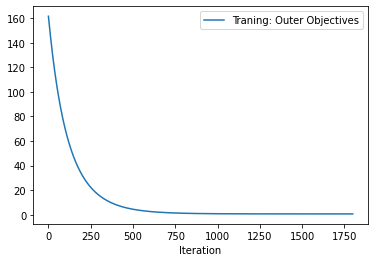

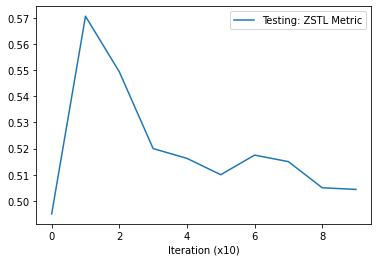

mean metric 0.504375
New best acc 0.504375
rho for w_kb 1; mu for a_kb 0.1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 16.599218368530273
1/1800 o_loss 161.5289858778318; m train metric 0.4972916666666663; m test metric 0.495; align loss  0.03535652160644531
200/1800 o_loss 32.348900277415915; m train metric 0.6319791666666664; m test metric 0.5706249999999999; align loss  0.02154541015625
400/1800 o_loss 8.204014069835345; m train metric 0.6231249999999999; m test metric 0.549375; align loss  0.014628410339355469
600/1800 o_loss 2.660801873107751; m train metric 0.6066666666666669; m test metric 0.52; align loss  0.010151386260986328
800/1800 o_loss 1.2320761139194172; m train metric 0.5810416666666668; m test metric 0.51625; align loss  0.007069826126098633
1000/1800 o_loss 0.8410083924730619; m train metric 0.5240625000000003; m tes

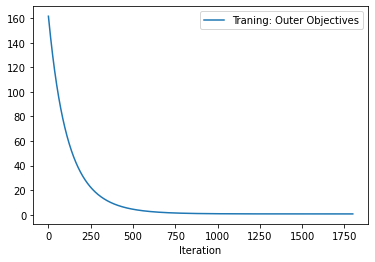

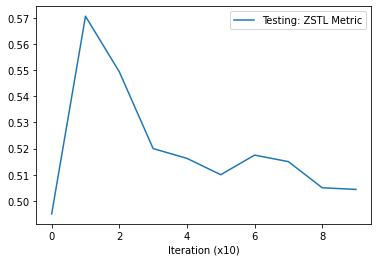

mean metric 0.5043749999999999
rho for w_kb 1; mu for a_kb 0.01;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.49562499999999987; align loss 1.6600748300552368
1/1800 o_loss 161.5289858778318; m train metric 0.4972916666666665; m test metric 0.49499999999999994; align loss  0.0036821365356445312
200/1800 o_loss 32.34890027344227; m train metric 0.6319791666666668; m test metric 0.5706249999999999; align loss  0.002299189567565918
400/1800 o_loss 8.204014067848524; m train metric 0.6231249999999999; m test metric 0.549375; align loss  0.001571357250213623
600/1800 o_loss 2.660801875591278; m train metric 0.6066666666666668; m test metric 0.52; align loss  0.001084744930267334
800/1800 o_loss 1.2320760945479075; m train metric 0.5810416666666669; m test metric 0.5162500000000001; align loss  0.0007498562335968018
1000/1800 o_loss 0.8410084024071693; m train m

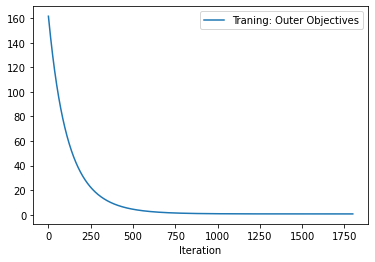

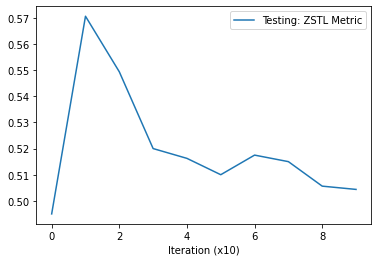

mean metric 0.504375
New best acc 0.504375
rho for w_kb 1; mu for a_kb 0.001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 0.16616056859493256
1/1800 o_loss 161.5289858778318; m train metric 0.4972916666666664; m test metric 0.495; align loss  0.0005149990320205688
200/1800 o_loss 32.3489002669851; m train metric 0.631979166666667; m test metric 0.5706249999999999; align loss  0.000374622642993927
400/1800 o_loss 8.204014060397943; m train metric 0.623125; m test metric 0.5493749999999998; align loss  0.0002654716372489929
600/1800 o_loss 2.6608018681406973; m train metric 0.6066666666666669; m test metric 0.5200000000000001; align loss  0.00017800182104110718
800/1800 o_loss 1.2320761173963546; m train metric 0.5810416666666668; m test metric 0.51625; align loss  0.00011795386672019958
1000/1800 o_loss 0.841008389989535; m tra

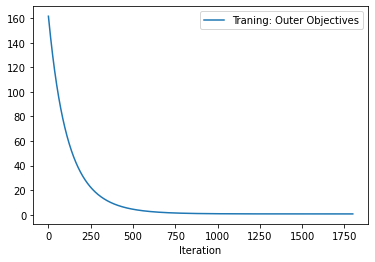

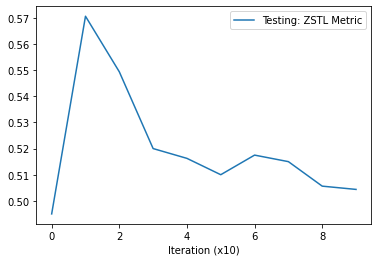

mean metric 0.5043749999999999
rho for w_kb 1; mu for a_kb 0.0001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.016769124194979668
1/1800 o_loss 161.5289858778318; m train metric 0.4972916666666666; m test metric 0.495; align loss  0.00019830651581287384
200/1800 o_loss 32.34890021433433; m train metric 0.6319791666666669; m test metric 0.5706249999999999; align loss  0.00018217507749795914
400/1800 o_loss 8.20401399632295; m train metric 0.623125; m test metric 0.549375; align loss  0.00013488112017512321
600/1800 o_loss 2.6608018214503923; m train metric 0.606666666666667; m test metric 0.52; align loss  8.732546120882034e-05
800/1800 o_loss 1.2320760587851205; m train metric 0.5809374999999997; m test metric 0.5162500000000001; align loss  5.4765259847044945e-05
1000/1800 o_loss 0.8410083636641502; m train metric 0.5239583333333334;

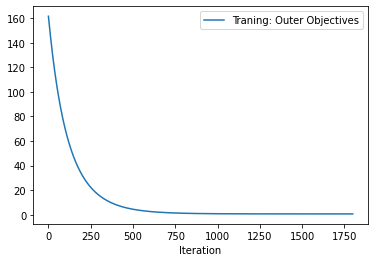

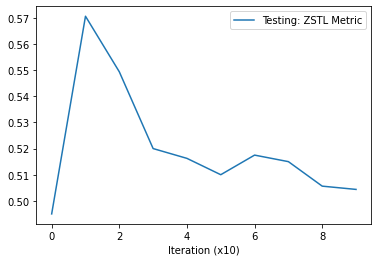

mean metric 0.5043749999999999
rho for w_kb 1; mu for a_kb 1e-05;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.0018299808725714684
1/1800 o_loss 161.5289858778318; m train metric 0.49729166666666635; m test metric 0.495; align loss  0.00016663549467921257
200/1800 o_loss 32.34889970819155; m train metric 0.6318750000000001; m test metric 0.5700000000000001; align loss  0.0001628650352358818
400/1800 o_loss 8.204013440509637; m train metric 0.6231249999999997; m test metric 0.549375; align loss  0.00012184953084215522
600/1800 o_loss 2.6608017017443975; m train metric 0.6066666666666667; m test metric 0.520625; align loss  7.831933908164501e-05
800/1800 o_loss 1.2320758670568466; m train metric 0.5809375000000003; m test metric 0.5162500000000001; align loss  4.850438563153148e-05
1000/1800 o_loss 0.8410082295536995; m train metric 0.52

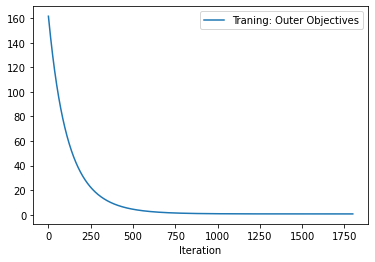

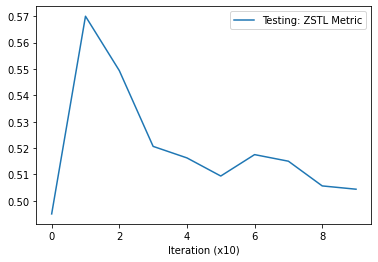

mean metric 0.504375
New best acc 0.504375
rho for w_kb 0.1; mu for a_kb 1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 165.9906463623047
1/1800 o_loss 16.78602208693822; m train metric 0.4960416666666666; m test metric 0.495625; align loss  0.352081298828125
200/1800 o_loss 3.842572798828284; m train metric 0.6623958333333333; m test metric 0.6331249999999999; align loss  0.21396636962890625
400/1800 o_loss 1.436942488948504; m train metric 0.6567708333333333; m test metric 0.626875; align loss  0.1452178955078125
600/1800 o_loss 0.8867108171184858; m train metric 0.6393749999999999; m test metric 0.6175; align loss  0.1008148193359375
800/1800 o_loss 0.7456041388213634; m train metric 0.6042708333333336; m test metric 0.589375; align loss  0.07025909423828125
1000/1800 o_loss 0.7071876214196284; m train metric 0.5677083333333334; m te

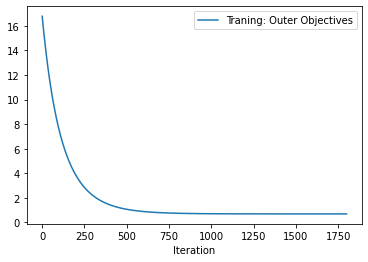

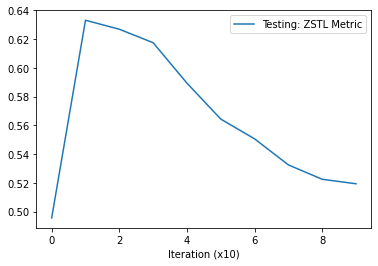

mean metric 0.5193749999999999
New best acc 0.5193749999999999
rho for w_kb 0.1; mu for a_kb 0.1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 16.599218368530273
1/1800 o_loss 16.78602208693822; m train metric 0.49604166666666666; m test metric 0.49562499999999987; align loss  0.03535652160644531
200/1800 o_loss 3.8425727998216948; m train metric 0.6623958333333333; m test metric 0.6331250000000002; align loss  0.021539688110351562
400/1800 o_loss 1.436942491432031; m train metric 0.6567708333333333; m test metric 0.6268750000000001; align loss  0.014627456665039062
600/1800 o_loss 0.8867108191053072; m train metric 0.6393749999999999; m test metric 0.6174999999999999; align loss  0.010150909423828125
800/1800 o_loss 0.7456041286389032; m train metric 0.6042708333333331; m test metric 0.5893750000000002; align loss  0.007069826126098633


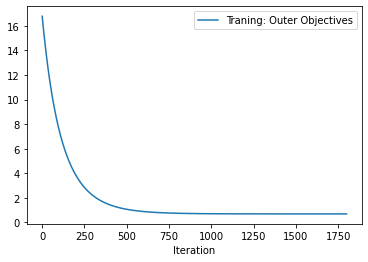

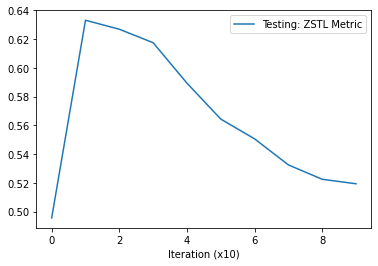

mean metric 0.5193749999999999
New best acc 0.5193749999999999
rho for w_kb 0.1; mu for a_kb 0.01;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 1.6600748300552368
1/1800 o_loss 16.78602208693822; m train metric 0.4960416666666665; m test metric 0.495625; align loss  0.0036821365356445312
200/1800 o_loss 3.8425727993249894; m train metric 0.6623958333333331; m test metric 0.633125; align loss  0.0022939443588256836
400/1800 o_loss 1.4369424894452094; m train metric 0.6567708333333336; m test metric 0.6268750000000001; align loss  0.0015701055526733398
600/1800 o_loss 0.8867108156283696; m train metric 0.6393749999999999; m test metric 0.6174999999999999; align loss  0.001084446907043457
800/1800 o_loss 0.7456041403114796; m train metric 0.6042708333333332; m test metric 0.589375; align loss  0.0007497668266296387
1000/1800 o_loss 0.707187

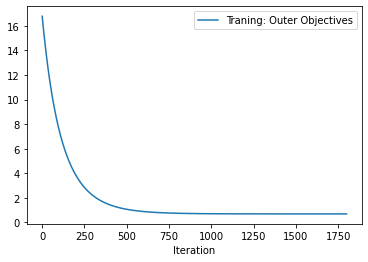

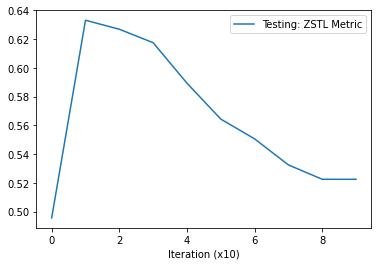

mean metric 0.5225
New best acc 0.5225
rho for w_kb 0.1; mu for a_kb 0.001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.16616056859493256
1/1800 o_loss 16.78602208693822; m train metric 0.49604166666666644; m test metric 0.49562499999999987; align loss  0.0005149990320205688
200/1800 o_loss 3.8425727943579355; m train metric 0.6623958333333333; m test metric 0.633125; align loss  0.0003694072365760803
400/1800 o_loss 1.4369424819946288; m train metric 0.6567708333333333; m test metric 0.6268749999999998; align loss  0.0002642124891281128
600/1800 o_loss 0.8867108076810837; m train metric 0.6393749999999998; m test metric 0.6174999999999999; align loss  0.0001777075231075287
800/1800 o_loss 0.7456041278938452; m train metric 0.6042708333333331; m test metric 0.5893750000000001; align loss  0.00011787936091423035
1000/1800 o_loss 0.7071

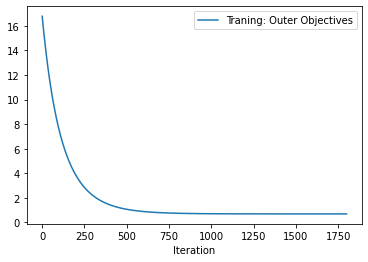

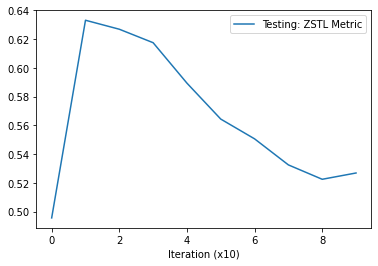

mean metric 0.5268750000000001
New best acc 0.5268750000000001
rho for w_kb 0.1; mu for a_kb 0.0001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 0.016769124194979668
1/1800 o_loss 16.78602208693822; m train metric 0.4960416666666665; m test metric 0.495625; align loss  0.0001983046531677246
200/1800 o_loss 3.8425727625687918; m train metric 0.6623958333333331; m test metric 0.6331249999999999; align loss  0.00017696432769298553
400/1800 o_loss 1.4369424358010292; m train metric 0.6567708333333336; m test metric 0.6268750000000001; align loss  0.00013361731544137
600/1800 o_loss 0.8867107853293419; m train metric 0.639375; m test metric 0.6174999999999999; align loss  8.703209459781647e-05
800/1800 o_loss 0.7456040968497594; m train metric 0.6043750000000002; m test metric 0.5893749999999999; align loss  5.469284951686859e-05
1

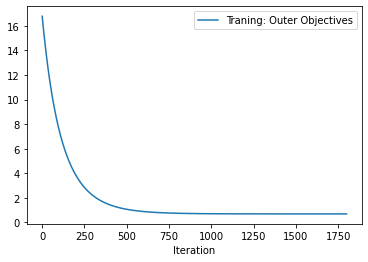

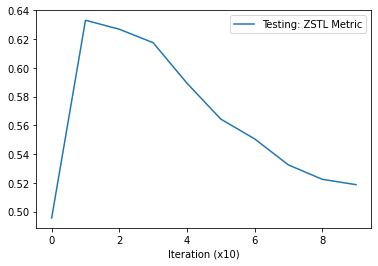

mean metric 0.51875
rho for w_kb 0.1; mu for a_kb 1e-05;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.0018299808725714684
1/1800 o_loss 16.78602208693822; m train metric 0.4960416666666667; m test metric 0.495625; align loss  0.00016663339920341969
200/1800 o_loss 3.8425724039475124; m train metric 0.6625000000000003; m test metric 0.6337499999999999; align loss  0.00015765498392283916
400/1800 o_loss 1.4369420180718104; m train metric 0.6567708333333332; m test metric 0.626875; align loss  0.00012058584252372384
600/1800 o_loss 0.8867104013760885; m train metric 0.6394791666666665; m test metric 0.6174999999999999; align loss  7.802568143233657e-05
800/1800 o_loss 0.7456037722527981; m train metric 0.604375; m test metric 0.589375; align loss  4.843174247071147e-05
1000/1800 o_loss 0.7071872547268867; m train metric 0.5677083333333336

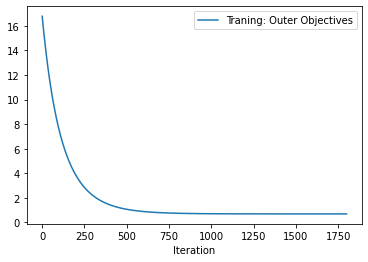

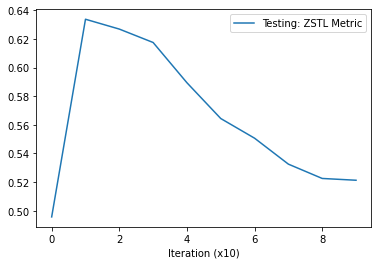

mean metric 0.52125
rho for w_kb 0.01; mu for a_kb 1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 165.9906463623047
1/1800 o_loss 2.3117252786954245; m train metric 0.5028125000000002; m test metric 0.5037499999999999; align loss  0.352081298828125
200/1800 o_loss 1.0205584600567819; m train metric 0.6744791666666666; m test metric 0.655; align loss  0.21396636962890625
400/1800 o_loss 0.7618564938505491; m train metric 0.6891666666666668; m test metric 0.6587500000000001; align loss  0.14521026611328125
600/1800 o_loss 0.7061464857310057; m train metric 0.7051041666666668; m test metric 0.6575; align loss  0.1008148193359375
800/1800 o_loss 0.6926103024433057; m train metric 0.7125; m test metric 0.6593749999999999; align loss  0.07025909423828125
1000/1800 o_loss 0.6891540274644892; m train metric 0.7116666666666668; m test 

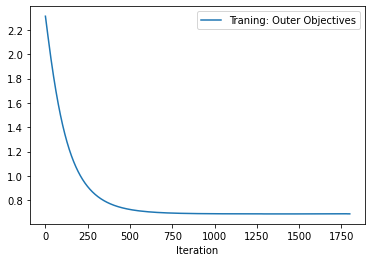

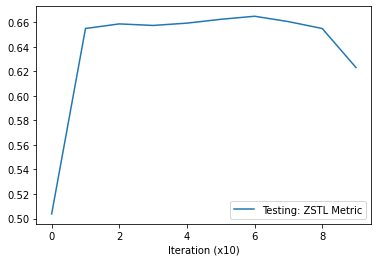

mean metric 0.623125
New best acc 0.623125
rho for w_kb 0.01; mu for a_kb 0.1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 16.599218368530273
1/1800 o_loss 2.3117252786954245; m train metric 0.5028125000000002; m test metric 0.50375; align loss  0.03535652160644531
200/1800 o_loss 1.0205584595600765; m train metric 0.6744791666666667; m test metric 0.655; align loss  0.021533966064453125
400/1800 o_loss 0.7618564938505491; m train metric 0.6891666666666669; m test metric 0.65875; align loss  0.014625072479248047
600/1800 o_loss 0.7061458549151818; m train metric 0.7048958333333333; m test metric 0.6549999999999999; align loss  0.010149955749511719
800/1800 o_loss 0.6926096377273401; m train metric 0.7125000000000002; m test metric 0.6587500000000001; align loss  0.007069110870361328
1000/1800 o_loss 0.6891537186068794; m train metric 0.

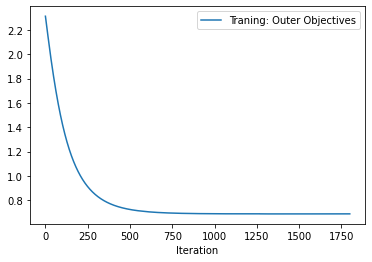

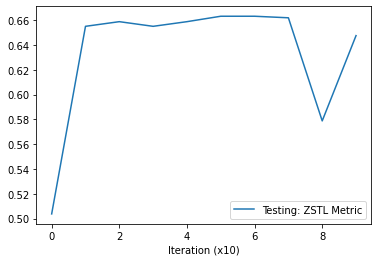

mean metric 0.6475
New best acc 0.6475
rho for w_kb 0.01; mu for a_kb 0.01;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 1.6600748300552368
1/1800 o_loss 2.3117252786954245; m train metric 0.5028125; m test metric 0.50375; align loss  0.0036826133728027344
200/1800 o_loss 1.0205584620436032; m train metric 0.6744791666666665; m test metric 0.6549999999999999; align loss  0.0022885799407958984
400/1800 o_loss 0.7618564854065577; m train metric 0.6891666666666666; m test metric 0.6587500000000001; align loss  0.0015679001808166504
600/1800 o_loss 0.7061461900671323; m train metric 0.7047916666666665; m test metric 0.654375; align loss  0.0010832548141479492
800/1800 o_loss 0.6926099404692649; m train metric 0.7125000000000002; m test metric 0.6599999999999999; align loss  0.0007490813732147217
1000/1800 o_loss 0.6891534830443561;

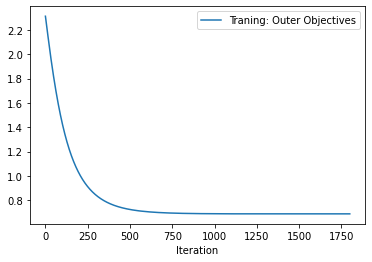

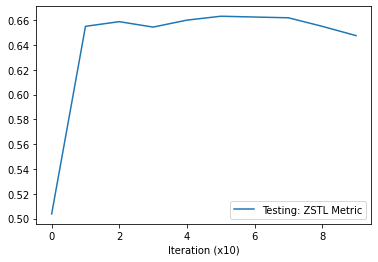

mean metric 0.6475
New best acc 0.6475
rho for w_kb 0.01; mu for a_kb 0.001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.16616056859493256
1/1800 o_loss 2.3117252786954245; m train metric 0.5028125000000002; m test metric 0.50375; align loss  0.0005154013633728027
200/1800 o_loss 1.020558455089728; m train metric 0.6744791666666669; m test metric 0.655; align loss  0.00036401301622390747
400/1800 o_loss 0.7618564719955127; m train metric 0.6891666666666668; m test metric 0.6587500000000002; align loss  0.0002619698643684387
600/1800 o_loss 0.7061463172237078; m train metric 0.7030208333333337; m test metric 0.6575; align loss  0.00017654523253440857
800/1800 o_loss 0.6926107605298361; m train metric 0.7124999999999998; m test metric 0.659375; align loss  0.00011718645691871643
1000/1800 o_loss 0.689153838219742; m train metric 0.71166

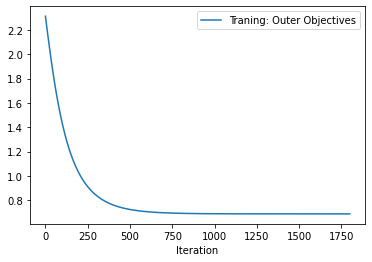

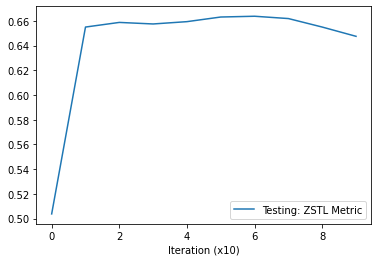

mean metric 0.6475
New best acc 0.6475
rho for w_kb 0.01; mu for a_kb 0.0001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 0.016769124194979668
1/1800 o_loss 2.3117252786954245; m train metric 0.5028125000000001; m test metric 0.5037499999999999; align loss  0.00019869953393936157
200/1800 o_loss 1.0205584769447644; m train metric 0.6744791666666666; m test metric 0.655; align loss  0.00017156917601823807
400/1800 o_loss 0.7618564342459043; m train metric 0.6891666666666669; m test metric 0.6587500000000002; align loss  0.0001313728280365467
600/1800 o_loss 0.7061463747173548; m train metric 0.7031250000000001; m test metric 0.6575; align loss  8.586747571825981e-05
800/1800 o_loss 0.6926105367019773; m train metric 0.7124999999999998; m test metric 0.659375; align loss  5.399901419878006e-05
1000/1800 o_loss 0.6891536846756935

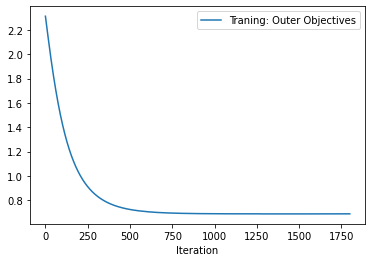

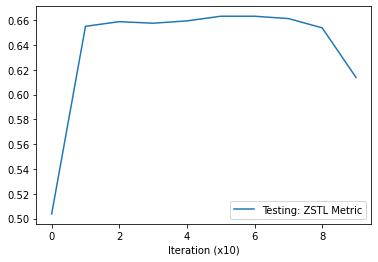

mean metric 0.61375
rho for w_kb 0.01; mu for a_kb 1e-05;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 0.0018299808725714684
1/1800 o_loss 2.3117252786954245; m train metric 0.5028125000000002; m test metric 0.5037499999999999; align loss  0.00016702827997505665
200/1800 o_loss 1.0205581307411193; m train metric 0.6744791666666665; m test metric 0.655; align loss  0.00015226006507873535
400/1800 o_loss 0.7618559290965398; m train metric 0.6891666666666667; m test metric 0.6587500000000001; align loss  0.00011834007455036044
600/1800 o_loss 0.7061455757667621; m train metric 0.7046874999999997; m test metric 0.6556249999999999; align loss  7.686024764552712e-05
800/1800 o_loss 0.6926091125234961; m train metric 0.7123958333333333; m test metric 0.659375; align loss  4.7737325076013803e-05
1000/1800 o_loss 0.6891522594417134; m t

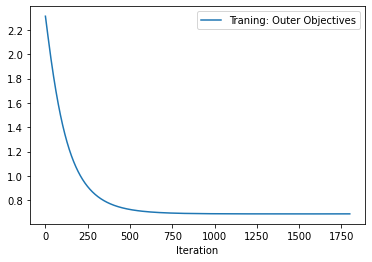

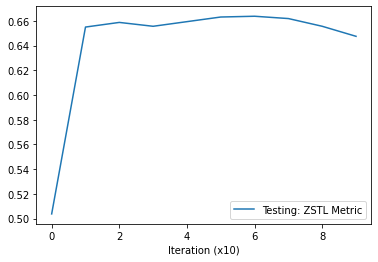

mean metric 0.6474999999999999
rho for w_kb 0.001; mu for a_kb 1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 165.9906463623047
1/1800 o_loss 0.864295651515325; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.352081298828125
200/1800 o_loss 0.7461317400137584; m train metric 0.6828124999999997; m test metric 0.659375; align loss  0.21395111083984375
400/1800 o_loss 0.6928962734838326; m train metric 0.7109374999999998; m test metric 0.6674999999999999; align loss  0.14519500732421875
600/1800 o_loss 0.6671146375437578; m train metric 0.735208333333333; m test metric 0.6831250000000001; align loss  0.10081100463867188
800/1800 o_loss 0.656865785519282; m train metric 0.7501041666666669; m test metric 0.6906249999999999; align loss  0.07027435302734375
1000/1800 o_loss 0.6532776021709045; m train metric 0.75791666

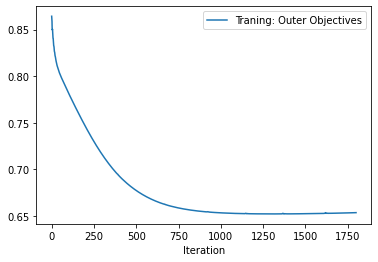

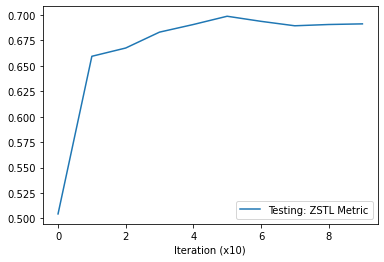

mean metric 0.69125
New best acc 0.69125
rho for w_kb 0.001; mu for a_kb 0.1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 16.599218368530273
1/1800 o_loss 0.864295651515325; m train metric 0.5028125000000001; m test metric 0.504375; align loss  0.03535652160644531
200/1800 o_loss 0.7461317454775175; m train metric 0.6828124999999996; m test metric 0.659375; align loss  0.021520614624023438
400/1800 o_loss 0.6929113614062468; m train metric 0.7112499999999997; m test metric 0.6681250000000001; align loss  0.014605998992919922
600/1800 o_loss 0.6671179619928201; m train metric 0.7352083333333337; m test metric 0.6831250000000001; align loss  0.010147571563720703
800/1800 o_loss 0.6568737802406152; m train metric 0.7501041666666666; m test metric 0.690625; align loss  0.007081270217895508
1000/1800 o_loss 0.6532804849247138; m train metric

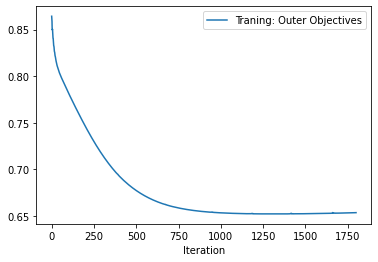

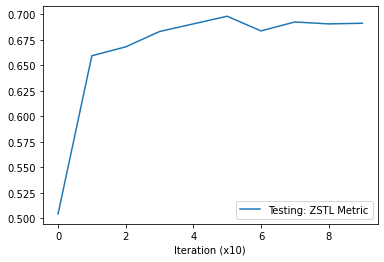

mean metric 0.69125
New best acc 0.69125
rho for w_kb 0.001; mu for a_kb 0.01;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 1.6600748300552368
1/1800 o_loss 0.864295651515325; m train metric 0.5028125000000003; m test metric 0.504375; align loss  0.0036826133728027344
200/1800 o_loss 0.7461317424972852; m train metric 0.6828125; m test metric 0.659375; align loss  0.0022742748260498047
400/1800 o_loss 0.692876170327266; m train metric 0.7120833333333335; m test metric 0.6656250000000001; align loss  0.0015485286712646484
600/1800 o_loss 0.6671112435559432; m train metric 0.7352083333333332; m test metric 0.6831250000000002; align loss  0.0010809898376464844
800/1800 o_loss 0.6568669070800145; m train metric 0.7501041666666668; m test metric 0.6906249999999999; align loss  0.0007613301277160645
1000/1800 o_loss 0.6532780750344197; m train

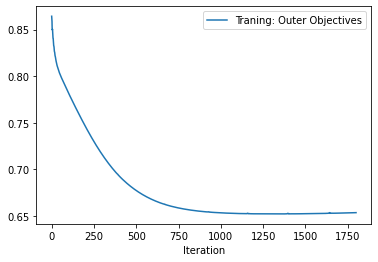

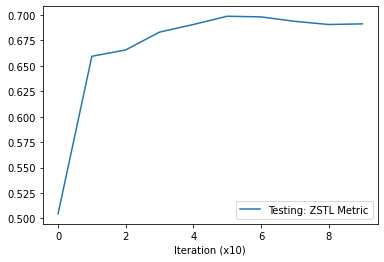

mean metric 0.6912499999999999
rho for w_kb 0.001; mu for a_kb 0.001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.16616056859493256
1/1800 o_loss 0.864295651515325; m train metric 0.5028125000000002; m test metric 0.5043749999999999; align loss  0.000515475869178772
200/1800 o_loss 0.7461317370335261; m train metric 0.6828125; m test metric 0.6593749999999999; align loss  0.0003497377038002014
400/1800 o_loss 0.6932060542205969; m train metric 0.7076041666666666; m test metric 0.6631250000000001; align loss  0.0002426356077194214
600/1800 o_loss 0.6672234517832597; m train metric 0.7352083333333331; m test metric 0.683125; align loss  0.00017424672842025757
800/1800 o_loss 0.6569002827008565; m train metric 0.7495833333333337; m test metric 0.6900000000000001; align loss  0.00012936070561408997
1000/1800 o_loss 0.6534660156816244; m t

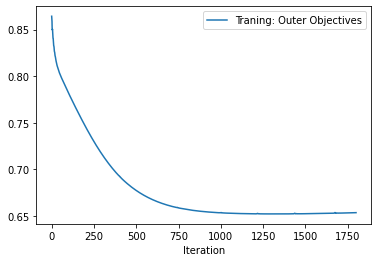

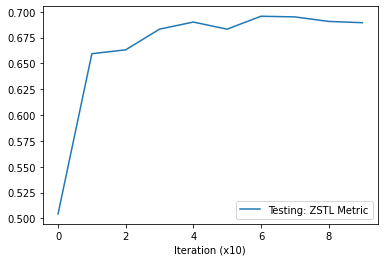

mean metric 0.689375
rho for w_kb 0.001; mu for a_kb 0.0001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.016769124194979668
1/1800 o_loss 0.864295651515325; m train metric 0.5028125000000001; m test metric 0.504375; align loss  0.00019878149032592773
200/1800 o_loss 0.7461316833893458; m train metric 0.6828125000000003; m test metric 0.659375; align loss  0.00015729758888483047
400/1800 o_loss 0.6928310212989648; m train metric 0.712708333333333; m test metric 0.663125; align loss  0.00011205114424228668
600/1800 o_loss 0.6671033841868241; m train metric 0.7352083333333334; m test metric 0.6831250000000002; align loss  8.359691128134727e-05
800/1800 o_loss 0.656868934382995; m train metric 0.7501041666666665; m test metric 0.6906249999999998; align loss  6.622867658734322e-05
1000/1800 o_loss 0.6532796287288268; m train metric 0.75791

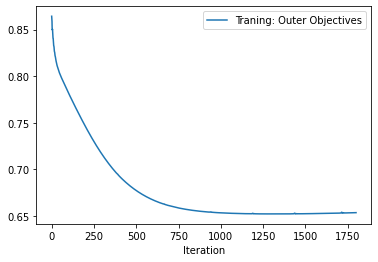

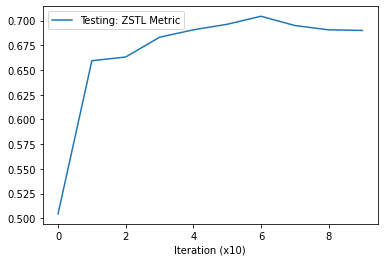

mean metric 0.6900000000000001
rho for w_kb 0.001; mu for a_kb 1e-05;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.0018299808725714684
1/1800 o_loss 0.864295651515325; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.00016711081843823195
200/1800 o_loss 0.7461312671502431; m train metric 0.6828124999999999; m test metric 0.659375; align loss  0.0001380097819492221
400/1800 o_loss 0.6928648844361305; m train metric 0.7103125000000002; m test metric 0.6668749999999999; align loss  9.900465374812484e-05
600/1800 o_loss 0.6670706945161025; m train metric 0.7351041666666667; m test metric 0.6825000000000002; align loss  7.456826278939843e-05
800/1800 o_loss 0.6568423425157864; m train metric 0.750104166666667; m test metric 0.690625; align loss  5.997472908347845e-05
1000/1800 o_loss 0.6532651368528605; m train metri

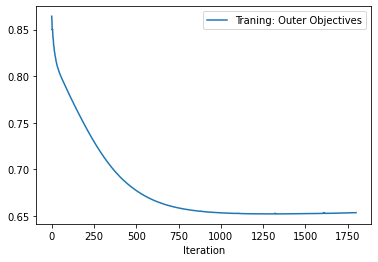

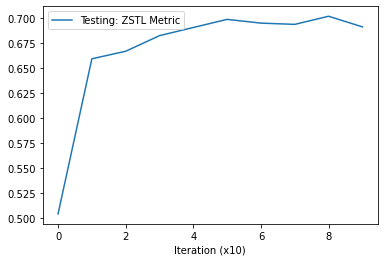

mean metric 0.6912499999999998
rho for w_kb 0.0001; mu for a_kb 1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 165.9906463623047
1/1800 o_loss 0.7195526820917925; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.352081298828125
200/1800 o_loss 0.6483311558763186; m train metric 0.6841666666666666; m test metric 0.6606249999999999; align loss  0.214019775390625
400/1800 o_loss 0.6277921094248692; m train metric 0.7167708333333336; m test metric 0.671875; align loss  0.1454010009765625
600/1800 o_loss 0.6093957727154096; m train metric 0.7406249999999996; m test metric 0.6781249999999999; align loss  0.10129165649414062
800/1800 o_loss 0.5937754965076844; m train metric 0.7577083333333334; m test metric 0.694375; align loss  0.07120513916015625
1000/1800 o_loss 0.58113472374777; m train metric 0.7707291666666667; m

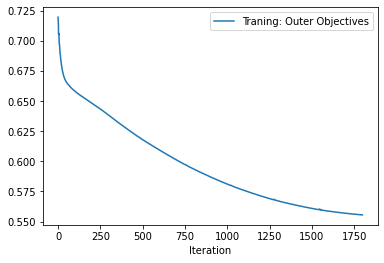

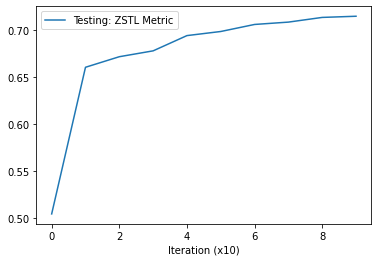

mean metric 0.7150000000000001
New best acc 0.7150000000000001
rho for w_kb 0.0001; mu for a_kb 0.1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 16.599218368530273
1/1800 o_loss 0.7195526820917925; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.03535652160644531
200/1800 o_loss 0.6483311568697293; m train metric 0.6841666666666665; m test metric 0.660625; align loss  0.021593093872070312
400/1800 o_loss 0.627792107189695; m train metric 0.7167708333333335; m test metric 0.6718749999999999; align loss  0.0148162841796875
600/1800 o_loss 0.609377583116293; m train metric 0.7406250000000001; m test metric 0.678125; align loss  0.01062774658203125
800/1800 o_loss 0.5937689275791248; m train metric 0.7572916666666671; m test metric 0.694375; align loss  0.008014678955078125
1000/1800 o_loss 0.5811597822854916; m tra

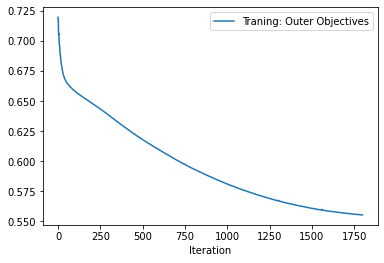

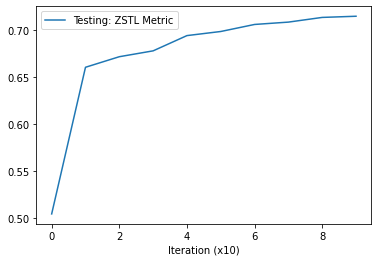

mean metric 0.7150000000000001
New best acc 0.7150000000000001
rho for w_kb 0.0001; mu for a_kb 0.01;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 1.6600748300552368
1/1800 o_loss 0.7195526820917925; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.0036826133728027344
200/1800 o_loss 0.6483311613400777; m train metric 0.6841666666666667; m test metric 0.6606250000000001; align loss  0.002347230911254883
400/1800 o_loss 0.627792107934753; m train metric 0.7167708333333334; m test metric 0.6718750000000001; align loss  0.0017592310905456543
600/1800 o_loss 0.6093520241479079; m train metric 0.7405208333333334; m test metric 0.678125; align loss  0.001561582088470459
800/1800 o_loss 0.593766925483942; m train metric 0.7570833333333337; m test metric 0.6943750000000001; align loss  0.0016947388648986816
1000/1800 o_lo

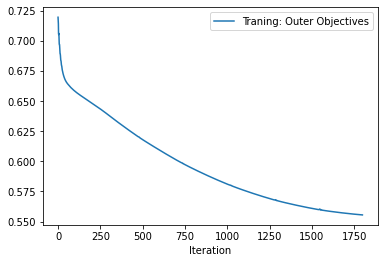

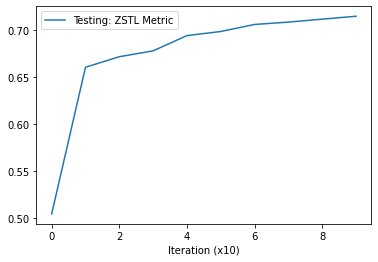

mean metric 0.7150000000000001
New best acc 0.7150000000000001
rho for w_kb 0.0001; mu for a_kb 0.001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 0.16616056859493256
1/1800 o_loss 0.7195526820917925; m train metric 0.5028125; m test metric 0.5043749999999999; align loss  0.000515475869178772
200/1800 o_loss 0.6483311499158542; m train metric 0.6841666666666665; m test metric 0.6606250000000001; align loss  0.0004226788878440857
400/1800 o_loss 0.6277920970072349; m train metric 0.7167708333333335; m test metric 0.671875; align loss  0.0004532933235168457
600/1800 o_loss 0.609440857047836; m train metric 0.7405208333333335; m test metric 0.6781250000000002; align loss  0.0006529279053211212
800/1800 o_loss 0.5937901747723421; m train metric 0.7586458333333334; m test metric 0.69375; align loss  0.001061759889125824
1000/1800 o

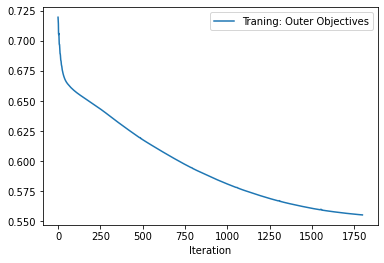

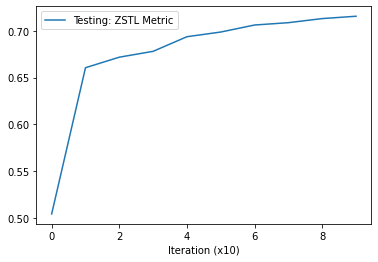

mean metric 0.715625
New best acc 0.715625
rho for w_kb 0.0001; mu for a_kb 0.0001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 0.016769124194979668
1/1800 o_loss 0.7195526820917925; m train metric 0.5028125000000002; m test metric 0.5043749999999999; align loss  0.00019878149032592773
200/1800 o_loss 0.6483311161398888; m train metric 0.6841666666666663; m test metric 0.660625; align loss  0.0002302415668964386
400/1800 o_loss 0.6277920181552569; m train metric 0.716770833333333; m test metric 0.671875; align loss  0.00032269442453980446
600/1800 o_loss 0.6094025836636623; m train metric 0.7406249999999999; m test metric 0.6781250000000001; align loss  0.0005630562081933022
800/1800 o_loss 0.5937694755693277; m train metric 0.75625; m test metric 0.6950000000000001; align loss  0.0009994334541261196
1000/1800 o_loss 0.5812002

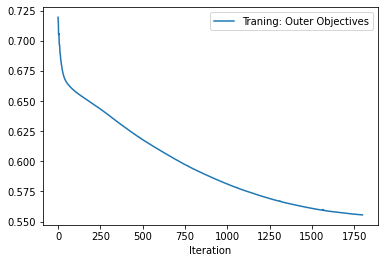

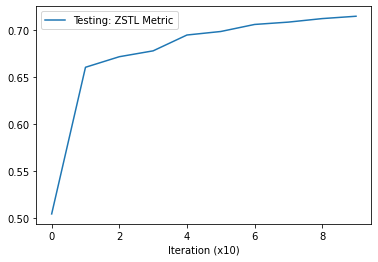

mean metric 0.715
rho for w_kb 0.0001; mu for a_kb 1e-05;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.0018299808725714684
1/1800 o_loss 0.7195526820917925; m train metric 0.5028125000000003; m test metric 0.504375; align loss  0.00016711081843823195
200/1800 o_loss 0.6483306929469108; m train metric 0.6841666666666664; m test metric 0.6606250000000002; align loss  0.00021097110584378242
400/1800 o_loss 0.6277911874155203; m train metric 0.7167708333333334; m test metric 0.6718750000000001; align loss  0.0003096094587817788
600/1800 o_loss 0.6093883667141199; m train metric 0.7406249999999998; m test metric 0.6781250000000001; align loss  0.0005541970604099333
800/1800 o_loss 0.5937690836687882; m train metric 0.7577083333333333; m test metric 0.6943750000000002; align loss  0.0009930209489539266
1000/1800 o_loss 0.581112576648593; m t

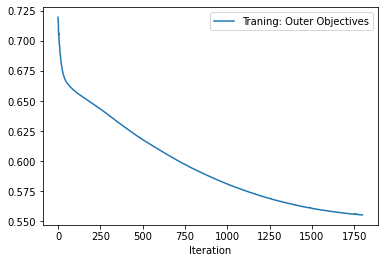

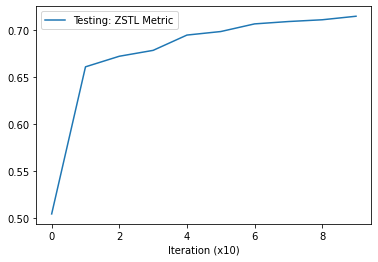

mean metric 0.7143750000000001
rho for w_kb 1e-05; mu for a_kb 1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4956250000000001; align loss 165.9906463623047
1/1800 o_loss 0.7050783858479311; m train metric 0.5028125000000002; m test metric 0.5043749999999999; align loss  0.352081298828125
200/1800 o_loss 0.6332356355541076; m train metric 0.6844791666666666; m test metric 0.661875; align loss  0.2140350341796875
400/1800 o_loss 0.6107417100652431; m train metric 0.7174999999999999; m test metric 0.670625; align loss  0.14548492431640625
600/1800 o_loss 0.5894511761919906; m train metric 0.7393749999999997; m test metric 0.6775; align loss  0.1015472412109375
800/1800 o_loss 0.5698675895730654; m train metric 0.757291666666667; m test metric 0.6912499999999999; align loss  0.07187271118164062
1000/1800 o_loss 0.5525705298253646; m train metric 0.7706249999

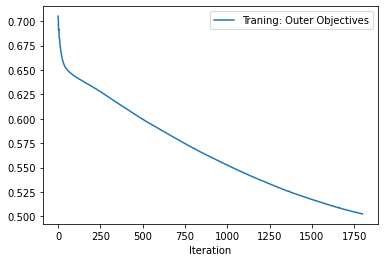

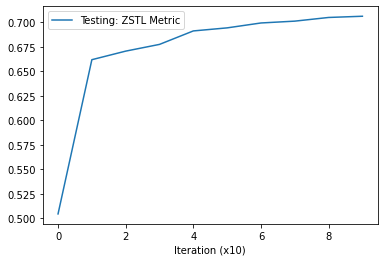

mean metric 0.70625
rho for w_kb 1e-05; mu for a_kb 0.1;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 16.599218368530273
1/1800 o_loss 0.7050783858479311; m train metric 0.5028125000000001; m test metric 0.504375; align loss  0.03535652160644531
200/1800 o_loss 0.6332356385343397; m train metric 0.6844791666666669; m test metric 0.6618749999999999; align loss  0.021608352661132812
400/1800 o_loss 0.6107417075817163; m train metric 0.7175000000000004; m test metric 0.670625; align loss  0.014896869659423828
600/1800 o_loss 0.5893999189759294; m train metric 0.739166666666667; m test metric 0.6775; align loss  0.01088571548461914
800/1800 o_loss 0.5698296354928364; m train metric 0.7571875000000003; m test metric 0.6906249999999998; align loss  0.008684158325195312
1000/1800 o_loss 0.5523686752965052; m train metric 0.7706250000000001; m t

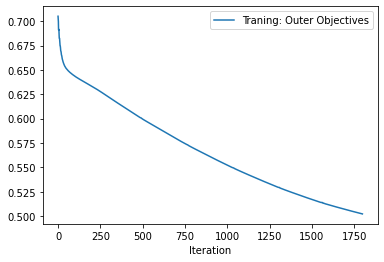

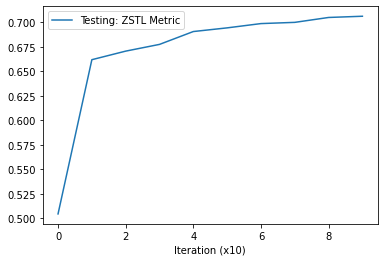

mean metric 0.70625
rho for w_kb 1e-05; mu for a_kb 0.01;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.49562499999999987; align loss 1.6600748300552368
1/1800 o_loss 0.7050783858479311; m train metric 0.5028125000000001; m test metric 0.5043750000000001; align loss  0.0036826133728027344
200/1800 o_loss 0.6332356367958709; m train metric 0.6844791666666664; m test metric 0.661875; align loss  0.0023622512817382812
400/1800 o_loss 0.6107417021179572; m train metric 0.7175; m test metric 0.6706249999999999; align loss  0.001839756965637207
600/1800 o_loss 0.5894147481148442; m train metric 0.7391666666666665; m test metric 0.6775; align loss  0.0018187761306762695
800/1800 o_loss 0.5698214237578213; m train metric 0.7567708333333337; m test metric 0.695; align loss  0.002364516258239746
1000/1800 o_loss 0.5524647651861111; m train metric 0.7706250000000001; 

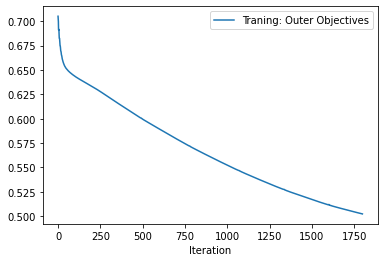

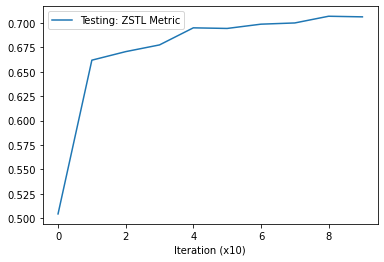

mean metric 0.7062499999999999
rho for w_kb 1e-05; mu for a_kb 0.001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.16616056859493256
1/1800 o_loss 0.7050783858479311; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.000515475869178772
200/1800 o_loss 0.6332356362991656; m train metric 0.6844791666666666; m test metric 0.661875; align loss  0.0004377439618110657
400/1800 o_loss 0.6107417013728991; m train metric 0.7174999999999997; m test metric 0.670625; align loss  0.0005338564515113831
600/1800 o_loss 0.5894538577801237; m train metric 0.7392708333333334; m test metric 0.6775; align loss  0.0009108707308769226
800/1800 o_loss 0.5698770989508678; m train metric 0.7568750000000002; m test metric 0.69125; align loss  0.0017296858131885529
1000/1800 o_loss 0.5525514532811939; m train metric 0.7706250000000001; m t

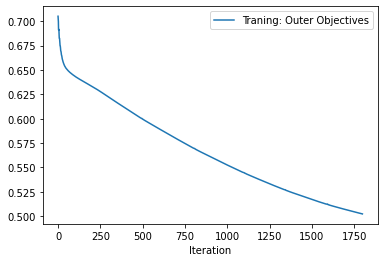

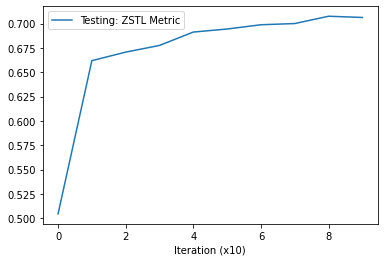

mean metric 0.7062499999999998
rho for w_kb 1e-05; mu for a_kb 0.0001;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.016769124194979668
1/1800 o_loss 0.7050783858479311; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.00019878149032592773
200/1800 o_loss 0.633235591595682; m train metric 0.6844791666666665; m test metric 0.661875; align loss  0.0002453075721859932
400/1800 o_loss 0.6107416243990883; m train metric 0.7174999999999997; m test metric 0.670625; align loss  0.0004032566212117672
600/1800 o_loss 0.589403337566182; m train metric 0.7392708333333334; m test metric 0.6775; align loss  0.0008217096328735352
800/1800 o_loss 0.5698346318366627; m train metric 0.7572916666666667; m test metric 0.691875; align loss  0.0016689961776137352
1000/1800 o_loss 0.5523599385749549; m train metric 0.7706250000000002; 

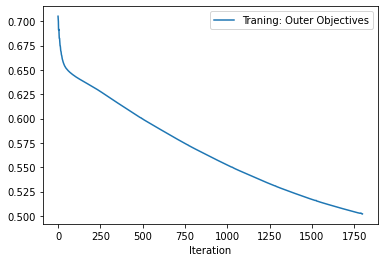

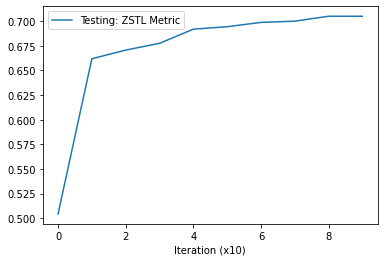

mean metric 0.7050000000000002
rho for w_kb 1e-05; mu for a_kb 1e-05;
softmax selected
test  torch.Size([312, 20]) torch.Size([2049, 20]) torch.Size([20, 80, 2049]) torch.Size([20, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.495625; align loss 0.0018299808725714684
1/1800 o_loss 0.7050783858479311; m train metric 0.5028125000000002; m test metric 0.504375; align loss  0.00016711081843823195
200/1800 o_loss 0.6332351897610351; m train metric 0.6844791666666665; m test metric 0.661875; align loss  0.0002260400215163827
400/1800 o_loss 0.6107408580835909; m train metric 0.7174999999999997; m test metric 0.670625; align loss  0.00039016688242554665
600/1800 o_loss 0.5893906298248718; m train metric 0.7391666666666664; m test metric 0.6775; align loss  0.0008128956542350352
800/1800 o_loss 0.5698242522465686; m train metric 0.7577083333333333; m test metric 0.6912499999999999; align loss  0.001663027796894312
1000/1800 o_loss 0.5524213114908586; m train metric 0.770624

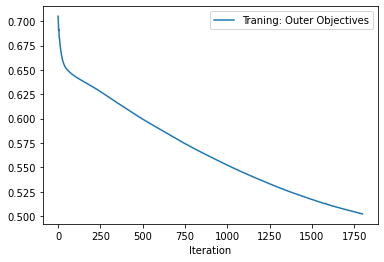

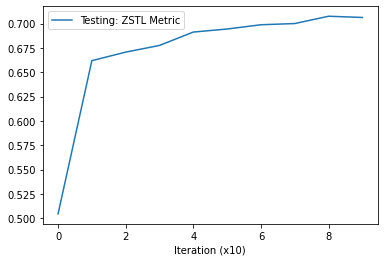

mean metric 0.7062499999999999
best_hp  {'mu': 0.001, 'rho': 0.0001}


In [ ]:
indx = train_indx
val_indx = list(np.random.choice(indx, size=20, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=int(len(val_indx)), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=int(len(train_indx_splited)), shuffle=True)

best_hp = utils.hp_select_binClass(train_splited_loader, val_loader, support_loader, d, dm, net, shape_record, device,\
                                   val_step=1800, activation='Softmax')
print('best_hp ', best_hp)

In [ ]:
def genSplits(dataset_split, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x+1 for x in range(len(dataset_split))]
    support_indx = list(np.random.choice(indx, size=support_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset_split[d] for d in support_indx])
    train_data = utils.Dataset([dataset_split[d] for d in train_indx])
    test_data = utils.Dataset([dataset_split[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=support_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=int(train_batch_size), shuffle=True)
    test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 140
test_size1 = 50
support_size1 = 10
#print(hp_tune_dataset[0])
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, len(dataset), train_batch_size=train_size1)

10
140
50


{'rho': 0.0001, 'mu': 0.001, 'loss': 'binary class', 'outer lr': 0.0001, 'align lr': 0.0001, 'dm': 312, 'd': 2049, 'model_shape': {0: [(1, 2049)]}, 'atten_activation': 'Softmax'}
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.49675; align loss 0.1814989298582077
1/1800 o_loss 0.7198734401060002; m train metric 0.49473214285714295; m test metric 0.49500000000000016; align loss  0.0004840940237045288
200/1800 o_loss 0.6686615831617798; m train metric 0.6528571428571429; m test metric 0.6622500000000001; align loss  0.000430181622505188
400/1800 o_loss 0.6610996583742754; m train metric 0.665892857142857; m test metric 0.6735000000000001; align loss  0.0004306286573410034
600/1800 o_loss 0.6538723076028483; m train metric 0.6769642857142859; m test metric 0.6779999999999999; align loss  0.00043892860412597656
800/1800 o_loss 0.6461983610476766; m trai

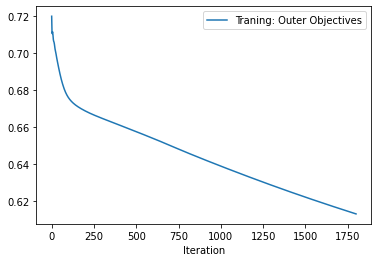

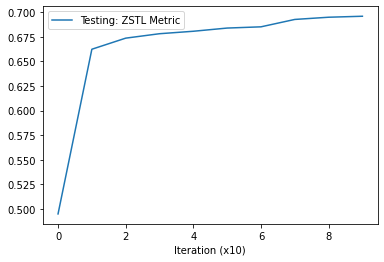

mean acc  tensor(0.6957, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4965; align loss 0.1728980541229248
1/1800 o_loss 0.7172773273395641; m train metric 0.4956249999999998; m test metric 0.49575; align loss  0.0003804713487625122
200/1800 o_loss 0.6634967567133052; m train metric 0.6865178571428571; m test metric 0.6502499999999999; align loss  0.0003492683172225952
400/1800 o_loss 0.6533033585974148; m train metric 0.6955357142857141; m test metric 0.6532500000000002; align loss  0.0003593266010284424
600/1800 o_loss 0.6444615682320936; m train metric 0.7023214285714288; m test metric 0.665; align loss  0.00037185847759246826
800/1800 o_loss 0.6356971250048705; m train metric 0.715535714285714; m test metric 0.66475; align loss  0.000398784875869751
1000/1800 o_loss 0.6271595616425787; m train metric 0.723

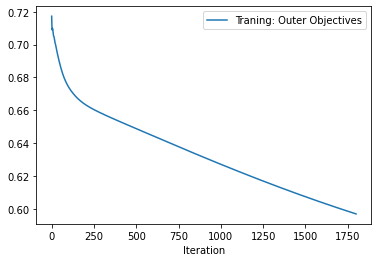

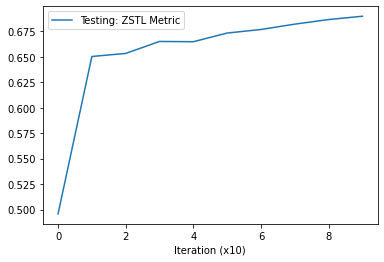

mean acc  tensor(0.6897, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4957500000000001; align loss 0.163094162940979
1/1800 o_loss 0.7165790003857442; m train metric 0.49928571428571433; m test metric 0.4879999999999999; align loss  0.0003581792116165161
200/1800 o_loss 0.664520051330328; m train metric 0.6798214285714286; m test metric 0.6707499999999998; align loss  0.0002646148204803467
400/1800 o_loss 0.6547365797949689; m train metric 0.7000892857142859; m test metric 0.6785000000000001; align loss  0.0002631545066833496
600/1800 o_loss 0.6461324871650763; m train metric 0.7118750000000004; m test metric 0.6844999999999999; align loss  0.0002652108669281006
800/1800 o_loss 0.6376367583870888; m train metric 0.7206249999999998; m test metric 0.6912500000000001; align loss  0.00027938932180404663
1000/1800

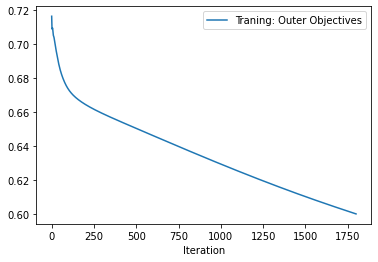

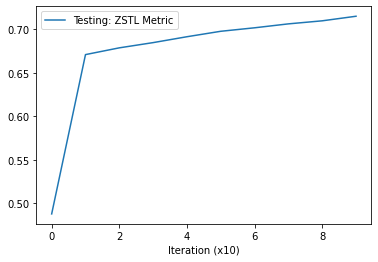

mean acc  tensor(0.7147, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4957500000000001; align loss 0.180773064494133
1/1800 o_loss 0.7172792127089841; m train metric 0.4950892857142855; m test metric 0.48774999999999996; align loss  0.00040124356746673584
200/1800 o_loss 0.66717040533466; m train metric 0.6764285714285713; m test metric 0.69; align loss  0.0003169924020767212
400/1800 o_loss 0.6574804640774216; m train metric 0.6937500000000002; m test metric 0.6927500000000001; align loss  0.00030368566513061523
600/1800 o_loss 0.6494104548756565; m train metric 0.7039285714285719; m test metric 0.6972500000000004; align loss  0.0003053992986679077
800/1800 o_loss 0.6419199659356049; m train metric 0.7124999999999999; m test metric 0.6972500000000003; align loss  0.0003227740526199341
1000/1800 o_loss 0.6347

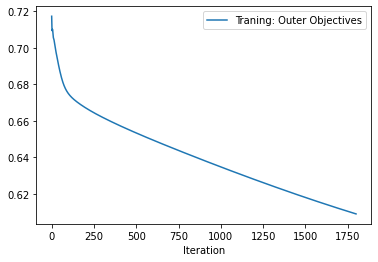

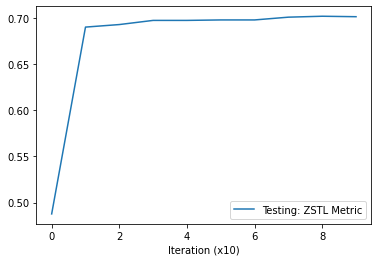

mean acc  tensor(0.7012, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4970000000000001; align loss 0.18709322810173035
1/1800 o_loss 0.7247168958187103; m train metric 0.4953571428571425; m test metric 0.4940000000000003; align loss  0.00035877525806427
200/1800 o_loss 0.6709149481994765; m train metric 0.6609821428571427; m test metric 0.6425; align loss  0.00034418702125549316
400/1800 o_loss 0.6617554516132389; m train metric 0.6803571428571425; m test metric 0.6517499999999998; align loss  0.00034590065479278564
600/1800 o_loss 0.6534527338509049; m train metric 0.696785714285714; m test metric 0.66625; align loss  0.00034499168395996094
800/1800 o_loss 0.6462779605495078; m train metric 0.709107142857143; m test metric 0.67175; align loss  0.00035950541496276855
1000/1800 o_loss 0.6392428728086608; m tra

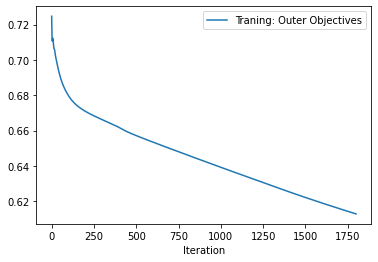

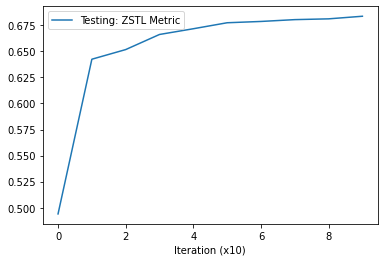

mean acc  tensor(0.6837, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4965000000000001; align loss 0.17030707001686096
1/1800 o_loss 0.7236780141613313; m train metric 0.4961607142857141; m test metric 0.49475000000000013; align loss  0.00029715895652770996
200/1800 o_loss 0.6705837007079806; m train metric 0.6529464285714289; m test metric 0.6892500000000001; align loss  0.00023840367794036865
400/1800 o_loss 0.6605300088013921; m train metric 0.677142857142857; m test metric 0.6987500000000001; align loss  0.00024053454399108887
600/1800 o_loss 0.6532501662948301; m train metric 0.6908928571428572; m test metric 0.7059999999999998; align loss  0.0002509802579879761
800/1800 o_loss 0.6465794993830578; m train metric 0.6983035714285718; m test metric 0.7082499999999999; align loss  0.000270158052444458
1000/1

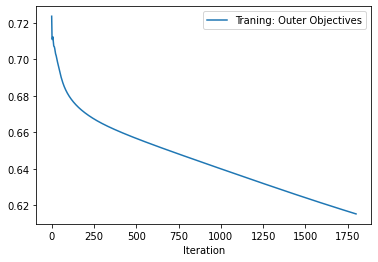

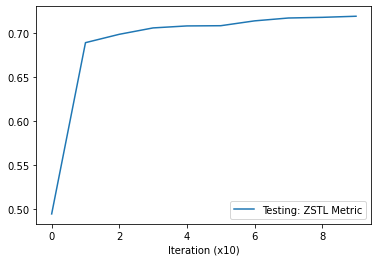

mean acc  tensor(0.7193, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4952500000000002; align loss 0.1758607178926468
1/1800 o_loss 0.718413959177477; m train metric 0.4925000000000002; m test metric 0.5049999999999999; align loss  0.0003097355365753174
200/1800 o_loss 0.6663439666586263; m train metric 0.6570535714285716; m test metric 0.623; align loss  0.00034555792808532715
400/1800 o_loss 0.6550907259540898; m train metric 0.6779464285714286; m test metric 0.6307499999999999; align loss  0.0003535747528076172
600/1800 o_loss 0.645991591577019; m train metric 0.6966071428571429; m test metric 0.6417500000000002; align loss  0.0003749579191207886
800/1800 o_loss 0.6375230204846177; m train metric 0.7094642857142857; m test metric 0.6517500000000002; align loss  0.0004188269376754761
1000/1800 o_loss 0.6291

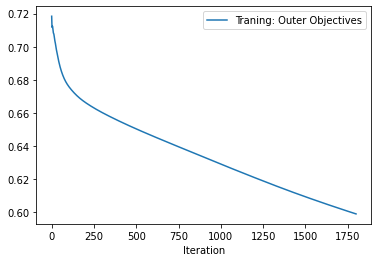

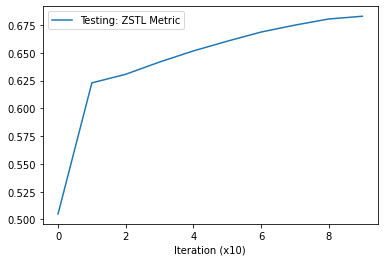

mean acc  tensor(0.6830, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4957500000000002; align loss 0.16627654433250427
1/1800 o_loss 0.7200497917298759; m train metric 0.4966071428571427; m test metric 0.49525000000000013; align loss  0.0004232078790664673
200/1800 o_loss 0.6586810966687543; m train metric 0.6878571428571431; m test metric 0.6695; align loss  0.0003227442502975464
400/1800 o_loss 0.649898782904659; m train metric 0.6971428571428571; m test metric 0.6769999999999999; align loss  0.0003137141466140747
600/1800 o_loss 0.642714964066233; m train metric 0.7053571428571429; m test metric 0.6805; align loss  0.00030806660652160645
800/1800 o_loss 0.6357548988291195; m train metric 0.713125; m test metric 0.68; align loss  0.00031454116106033325
1000/1800 o_loss 0.6285362514534166; m train metric 0.7

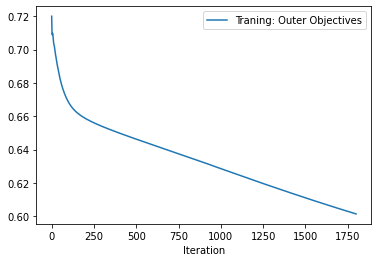

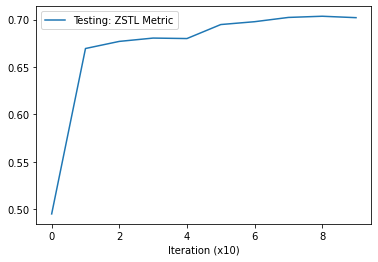

mean acc  tensor(0.7020, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4957500000000002; align loss 0.16867607831954956
1/1800 o_loss 0.729547267300742; m train metric 0.49491071428571437; m test metric 0.4932499999999999; align loss  0.00026722252368927
200/1800 o_loss 0.6677515950586115; m train metric 0.6499999999999999; m test metric 0.6147499999999999; align loss  0.00026144087314605713
400/1800 o_loss 0.6600265599787235; m train metric 0.6611607142857142; m test metric 0.624; align loss  0.00026667118072509766
600/1800 o_loss 0.6540416961801904; m train metric 0.6708928571428571; m test metric 0.63675; align loss  0.0002717524766921997
800/1800 o_loss 0.6479072939072337; m train metric 0.6845535714285713; m test metric 0.6497499999999999; align loss  0.00028277933597564697
1000/1800 o_loss 0.641668132373

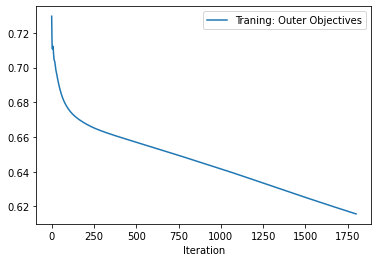

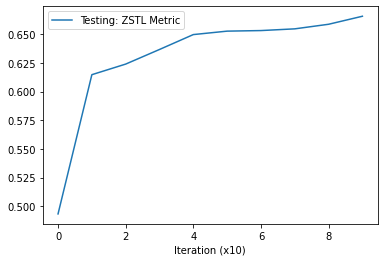

mean acc  tensor(0.6658, device='cuda:0', dtype=torch.float64)
10
140
50
softmax selected
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 10])
init mean test metric 0.4972500000000001; align loss 0.17360465228557587
1/1800 o_loss 0.7192372773907014; m train metric 0.49589285714285714; m test metric 0.49475000000000013; align loss  0.00026541948318481445
200/1800 o_loss 0.6731209646378244; m train metric 0.6526785714285713; m test metric 0.6335000000000001; align loss  0.00027742981910705566
400/1800 o_loss 0.6612248421779701; m train metric 0.6722321428571427; m test metric 0.6425; align loss  0.0002970099449157715
600/1800 o_loss 0.6524419616375651; m train metric 0.684196428571429; m test metric 0.65375; align loss  0.0003074854612350464
800/1800 o_loss 0.6438383805432489; m train metric 0.6975000000000001; m test metric 0.6592500000000001; align loss  0.00032930076122283936
1000/1800 o_loss 0.63552192

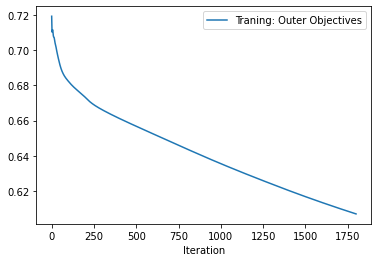

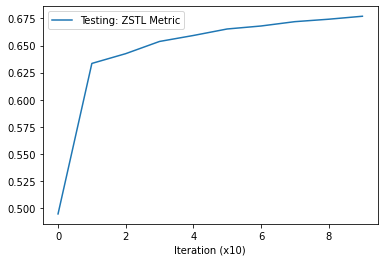

mean acc  tensor(0.6770, device='cuda:0', dtype=torch.float64)


In [ ]:
exp_results = []
Run = 10

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-4
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Softmax'
print(param_dict)

for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, len(dataset), train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
    ZSTL_model.train(train_loader, test_loader, max_iter=1800)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc.cpu()))


In [ ]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

[array(0.69575), array(0.68975), array(0.71475), array(0.70125), array(0.68375), array(0.71925), array(0.683), array(0.702), array(0.66575), array(0.677)]
0.693225
(0.6812715898080325, 0.7051784101919675)
[-0.01195341  0.01195341]


In [ ]:
param_dict

{'align lr': 0.0001,
 'atten_activation': 'Softmax',
 'd': 2049,
 'dm': 312,
 'loss': 'binary class',
 'model_shape': {0: [(1, 2049)]},
 'mu': 0.001,
 'outer lr': 0.0001,
 'rho': 0.0001}

#Effect of the number of entries in knowledge base

In [ ]:

param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 1e-5
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-3
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)





{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.001, 'dm': 312, 'd': 2049, 'model_shape': {0: [(1, 2049)]}, 'atten_activation': 'Sparsemax'}


In [ ]:
K  = [x for x in range(2, 33, 3)]
print(K)

test_size1 = 50
totSize = 200
#ZSTL_model.train(train_loader, test_loader, max_iter=2000)

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32]


148 2
2
148
50
knowledge base size  torch.Size([312, 2]) torch.Size([2049, 2])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 2])
init mean test metric 0.48750000000000004; align loss 0.003912326879799366
1/1500 o_loss 0.721744396847706; m train metric 0.5033928571428573; m test metric 0.50375; align loss  0.009467349387705326
200/1500 o_loss 0.7000259119302167; m train metric 0.5031250000000002; m test metric 0.49849999999999994; align loss  0.0068683139979839325
400/1500 o_loss 0.6985816891471456; m train metric 0.5066071428571427; m test metric 0.4962499999999999; align loss  0.006668999791145325
600/1500 o_loss 0.6970501210989564; m train metric 0.5083928571428572; m test metric 0.494; align loss  0.007616293616592884
800/1500 o_loss 0.6955535868099625; m train metric 0.5136607142857146; m test metric 0.48774999999999996; align loss  0.008749371394515038
1000/1500 o_loss 0.6940070296704237; m train 

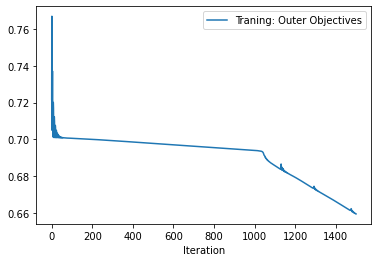

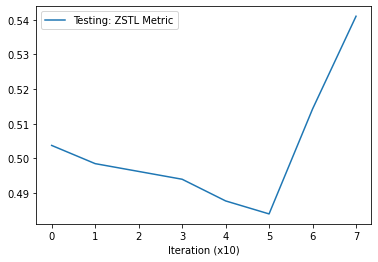

mean acc  tensor(0.5635, device='cuda:0', dtype=torch.float64)
148 2
2
148
50
knowledge base size  torch.Size([312, 2]) torch.Size([2049, 2])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 2])
init mean test metric 0.5032500000000001; align loss 0.006662696599960327
1/1500 o_loss 0.7030024200345256; m train metric 0.5030357142857146; m test metric 0.5032499999999999; align loss  0.0028970306739211082
200/1500 o_loss 0.6786275791952253; m train metric 0.5826785714285712; m test metric 0.5895000000000001; align loss  0.006390594411641359
400/1500 o_loss 0.6717788164445665; m train metric 0.6051785714285713; m test metric 0.6072500000000001; align loss  0.01199801079928875
600/1500 o_loss 0.6623781245043834; m train metric 0.6329464285714286; m test metric 0.6265; align loss  0.020757053047418594
800/1500 o_loss 0.6513016711679354; m train metric 0.6509821428571424; m test metric 0.6347499999999998; align 

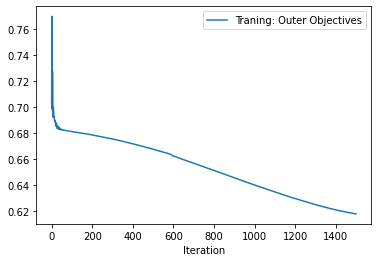

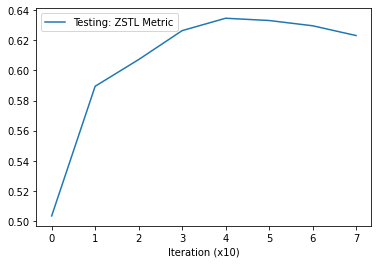

mean acc  tensor(0.6230, device='cuda:0', dtype=torch.float64)
148 2
2
148
50
knowledge base size  torch.Size([312, 2]) torch.Size([2049, 2])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 2])
init mean test metric 0.4965000000000001; align loss 0.0026073483750224113
1/1500 o_loss 0.7060158229482892; m train metric 0.5032142857142858; m test metric 0.5044999999999998; align loss  0.0033523296006023884
200/1500 o_loss 0.6608905130124185; m train metric 0.6255357142857143; m test metric 0.6250000000000001; align loss  0.013774010352790356
400/1500 o_loss 0.6538059884956705; m train metric 0.6372321428571431; m test metric 0.6342500000000002; align loss  0.025086021050810814
600/1500 o_loss 0.6458977556371662; m train metric 0.6450892857142853; m test metric 0.6404999999999998; align loss  0.039460014551877975
800/1500 o_loss 0.6378353967896796; m train metric 0.6482142857142856; m test metric 0.6382500000

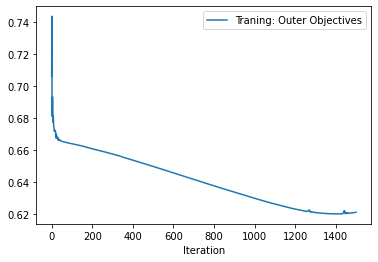

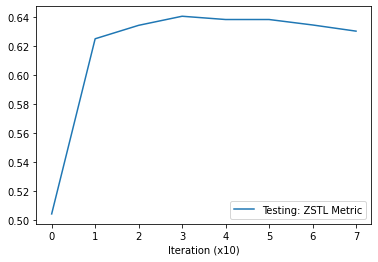

mean acc  tensor(0.6305, device='cuda:0', dtype=torch.float64)
148 2
2
148
50
knowledge base size  torch.Size([312, 2]) torch.Size([2049, 2])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 2])
init mean test metric 0.49999999999999994; align loss 0.0029562462586909533
1/1500 o_loss 0.7116554174064991; m train metric 0.503214285714286; m test metric 0.5042499999999999; align loss  0.00880022905766964
200/1500 o_loss 0.6820271901586759; m train metric 0.5535714285714288; m test metric 0.5395; align loss  0.010833385400474072
400/1500 o_loss 0.6757846728399661; m train metric 0.568392857142857; m test metric 0.5459999999999999; align loss  0.014420537278056145
600/1500 o_loss 0.6680364425202632; m train metric 0.5860714285714284; m test metric 0.5602499999999999; align loss  0.01943754218518734
800/1500 o_loss 0.6589101477301613; m train metric 0.6082142857142855; m test metric 0.578; align loss  0.0282600

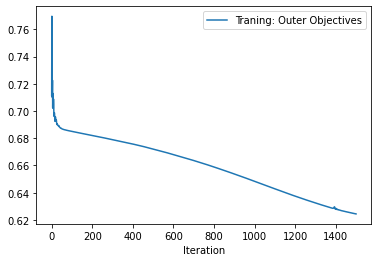

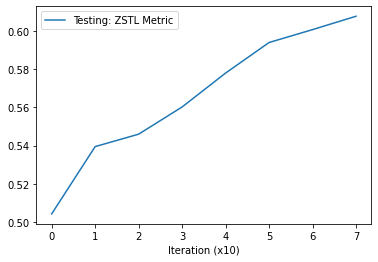

mean acc  tensor(0.6095, device='cuda:0', dtype=torch.float64)
148 2
2
148
50
knowledge base size  torch.Size([312, 2]) torch.Size([2049, 2])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 2])
init mean test metric 0.4937500000000001; align loss 0.01665349304676056
1/1500 o_loss 0.7218214500579051; m train metric 0.5040178571428573; m test metric 0.5015; align loss  0.020793836563825607
200/1500 o_loss 0.7015520784962324; m train metric 0.5070535714285717; m test metric 0.48924999999999985; align loss  0.0076133632101118565
400/1500 o_loss 0.7002066653030592; m train metric 0.5070535714285712; m test metric 0.4905; align loss  0.004260470159351826
600/1500 o_loss 0.6987222812570897; m train metric 0.5095535714285717; m test metric 0.4929999999999999; align loss  0.005087890196591616
800/1500 o_loss 0.6972158877702895; m train metric 0.5112499999999999; m test metric 0.48924999999999996; align loss  0.00

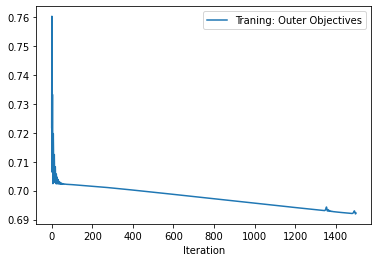

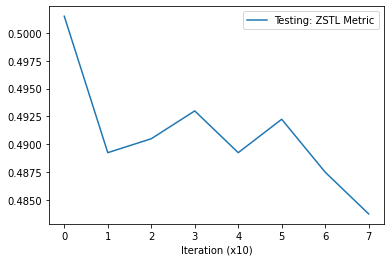

mean acc  tensor(0.4812, device='cuda:0', dtype=torch.float64)
k=2, mean_acc=0.58155
145 5
5
145
50
knowledge base size  torch.Size([312, 5]) torch.Size([2049, 5])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 5])
init mean test metric 0.50875; align loss 0.001926510245539248
1/1500 o_loss 0.7157158250571228; m train metric 0.5039285714285718; m test metric 0.5019999999999999; align loss  0.0007729670032858849
200/1500 o_loss 0.6563746172718571; m train metric 0.6108035714285717; m test metric 0.5884999999999999; align loss  0.0012468673521652818
400/1500 o_loss 0.6435627970628307; m train metric 0.631339285714286; m test metric 0.60175; align loss  0.0022462033666670322
600/1500 o_loss 0.6301417809911072; m train metric 0.6533035714285714; m test metric 0.6175; align loss  0.0045114061795175076
800/1500 o_loss 0.6177463746463348; m train metric 0.6707142857142859; m test metric 0.6287499999999998; ali

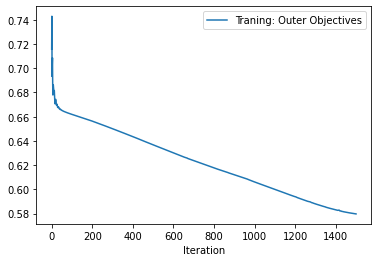

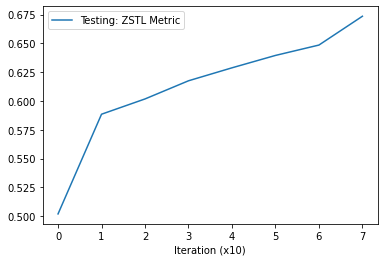

mean acc  tensor(0.6765, device='cuda:0', dtype=torch.float64)
145 5
5
145
50
knowledge base size  torch.Size([312, 5]) torch.Size([2049, 5])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 5])
init mean test metric 0.4977500000000001; align loss 0.001769951544702053
1/1500 o_loss 0.7086202357895672; m train metric 0.5036607142857146; m test metric 0.5027499999999999; align loss  0.0010200110264122486
200/1500 o_loss 0.6328984942852652; m train metric 0.6774107142857142; m test metric 0.61875; align loss  0.001098282402381301
400/1500 o_loss 0.6208226642205513; m train metric 0.6862500000000004; m test metric 0.6250000000000001; align loss  0.0027010729536414146
600/1500 o_loss 0.6074441624705547; m train metric 0.6930357142857143; m test metric 0.6287499999999998; align loss  0.005931809078902006
800/1500 o_loss 0.5940409079160808; m train metric 0.7032142857142857; m test metric 0.63175; align loss  0.

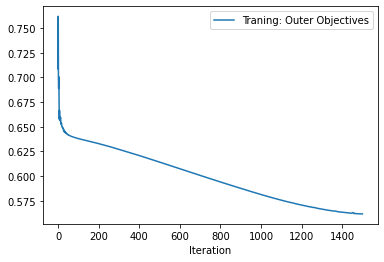

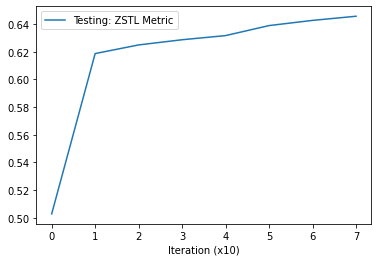

mean acc  tensor(0.6482, device='cuda:0', dtype=torch.float64)
145 5
5
145
50
knowledge base size  torch.Size([312, 5]) torch.Size([2049, 5])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 5])
init mean test metric 0.49699999999999994; align loss 0.0020085240248590708
1/1500 o_loss 0.7069779294226983; m train metric 0.503482142857143; m test metric 0.503; align loss  0.0010798329021781683
200/1500 o_loss 0.6521575049397402; m train metric 0.6465178571428569; m test metric 0.6375000000000002; align loss  0.001185663160867989
400/1500 o_loss 0.6396781687308768; m train metric 0.66625; m test metric 0.65675; align loss  0.0020481927786022425
600/1500 o_loss 0.6263852822394775; m train metric 0.6806249999999998; m test metric 0.6709999999999999; align loss  0.00391531502828002
800/1500 o_loss 0.613783097183997; m train metric 0.6892857142857142; m test metric 0.67375; align loss  0.007089880760759115
1000/1

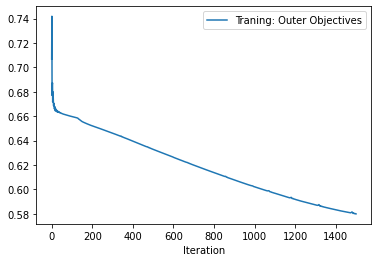

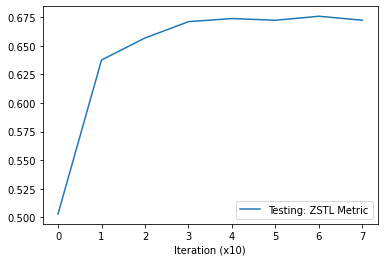

mean acc  tensor(0.6710, device='cuda:0', dtype=torch.float64)
145 5
5
145
50
knowledge base size  torch.Size([312, 5]) torch.Size([2049, 5])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 5])
init mean test metric 0.49625000000000014; align loss 0.002773480024188757
1/1500 o_loss 0.708717298170086; m train metric 0.5038392857142859; m test metric 0.5025; align loss  0.0017190342769026756
200/1500 o_loss 0.6472459374461322; m train metric 0.6532142857142857; m test metric 0.627; align loss  0.0018908961210399866
400/1500 o_loss 0.6374820137263408; m train metric 0.6684821428571428; m test metric 0.6315; align loss  0.0023398660123348236
600/1500 o_loss 0.6260586421670659; m train metric 0.6852678571428568; m test metric 0.6282499999999999; align loss  0.0035452800802886486
800/1500 o_loss 0.6138102714038853; m train metric 0.6991964285714284; m test metric 0.6337500000000003; align loss  0.0058379238471

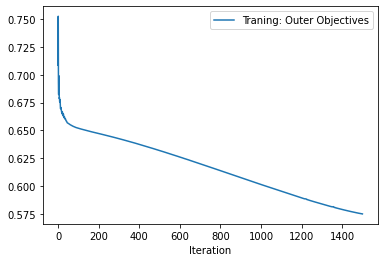

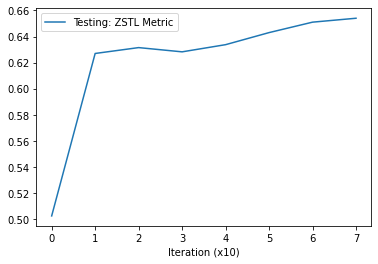

mean acc  tensor(0.6548, device='cuda:0', dtype=torch.float64)
145 5
5
145
50
knowledge base size  torch.Size([312, 5]) torch.Size([2049, 5])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 5])
init mean test metric 0.4952500000000001; align loss 0.001824663602747023
1/1500 o_loss 0.7130215900235011; m train metric 0.5035714285714289; m test metric 0.5047499999999999; align loss  0.0007766355411149561
200/1500 o_loss 0.6466466012676911; m train metric 0.6541071428571427; m test metric 0.6197499999999999; align loss  0.0013813511468470097
400/1500 o_loss 0.6337384054054772; m train metric 0.680267857142857; m test metric 0.6345000000000001; align loss  0.0022721965797245502
600/1500 o_loss 0.6158311765607712; m train metric 0.7037499999999995; m test metric 0.6505000000000001; align loss  0.004213395528495312
800/1500 o_loss 0.5992363441569198; m train metric 0.7247321428571427; m test metric 0.659; align

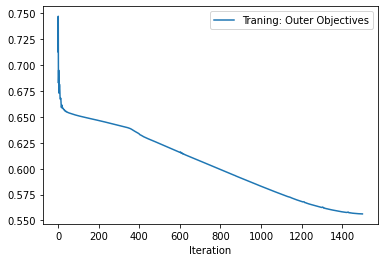

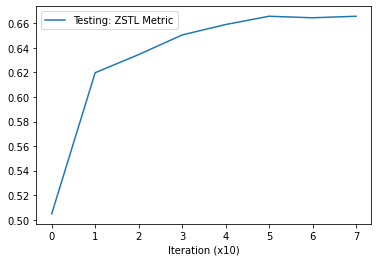

mean acc  tensor(0.6670, device='cuda:0', dtype=torch.float64)
k=5, mean_acc=0.6635
142 8
8
142
50
knowledge base size  torch.Size([312, 8]) torch.Size([2049, 8])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 8])
init mean test metric 0.4945000000000002; align loss 0.0018390176119282842
1/1500 o_loss 0.7033491337838184; m train metric 0.5032142857142858; m test metric 0.5039999999999999; align loss  0.0004086464177817106
200/1500 o_loss 0.6423843337987949; m train metric 0.6740178571428573; m test metric 0.67425; align loss  0.0003119629109278321
400/1500 o_loss 0.6299625443793567; m train metric 0.6928571428571434; m test metric 0.67125; align loss  0.0005485110450536013
600/1500 o_loss 0.6156303259843428; m train metric 0.7099107142857141; m test metric 0.6792499999999998; align loss  0.0010830180253833532
800/1500 o_loss 0.6008511566058067; m train metric 0.725982142857143; m test metric 0.679750000

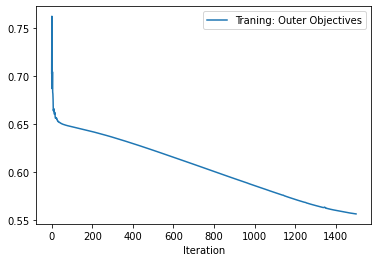

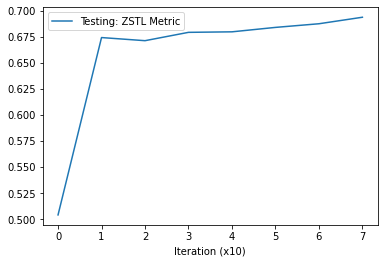

mean acc  tensor(0.6933, device='cuda:0', dtype=torch.float64)
142 8
8
142
50
knowledge base size  torch.Size([312, 8]) torch.Size([2049, 8])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 8])
init mean test metric 0.49425000000000013; align loss 0.0018212094437330961
1/1500 o_loss 0.7059274980033349; m train metric 0.5032142857142861; m test metric 0.5039999999999999; align loss  0.0003530107205733657
200/1500 o_loss 0.6473479322191061; m train metric 0.6532142857142856; m test metric 0.6137499999999999; align loss  0.0006524442578665912
400/1500 o_loss 0.6333084877148004; m train metric 0.6662499999999998; m test metric 0.627; align loss  0.0009349770843982697
600/1500 o_loss 0.6196806975207957; m train metric 0.6812500000000002; m test metric 0.63675; align loss  0.0015120713505893946
800/1500 o_loss 0.6078759400074237; m train metric 0.6924999999999998; m test metric 0.6450000000000001; align loss  

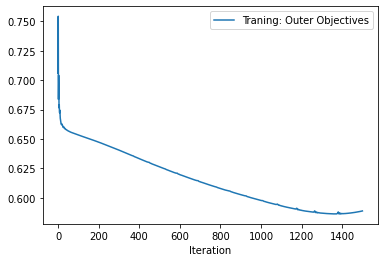

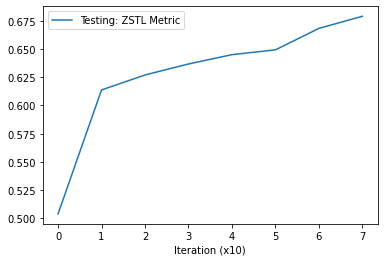

mean acc  tensor(0.6830, device='cuda:0', dtype=torch.float64)
142 8
8
142
50
knowledge base size  torch.Size([312, 8]) torch.Size([2049, 8])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 8])
init mean test metric 0.49675; align loss 0.001708245719783008
1/1500 o_loss 0.7055313797434791; m train metric 0.5036607142857146; m test metric 0.50325; align loss  0.00037566188257187605
200/1500 o_loss 0.6457435415791614; m train metric 0.6671428571428574; m test metric 0.6570000000000001; align loss  0.00041852332651615143
400/1500 o_loss 0.6347060195236865; m train metric 0.6829464285714286; m test metric 0.6670000000000001; align loss  0.0006615880411118269
600/1500 o_loss 0.6220321753727538; m train metric 0.7001785714285712; m test metric 0.6772500000000001; align loss  0.0011266397777944803
800/1500 o_loss 0.609131940986429; m train metric 0.7140178571428576; m test metric 0.6864999999999999; align loss 

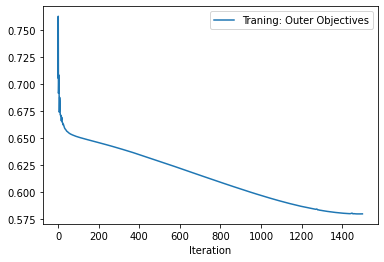

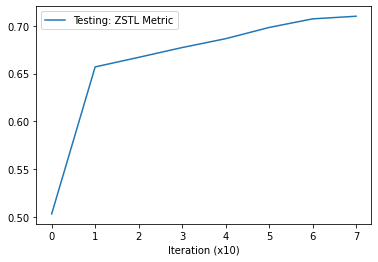

mean acc  tensor(0.7123, device='cuda:0', dtype=torch.float64)
142 8
8
142
50
knowledge base size  torch.Size([312, 8]) torch.Size([2049, 8])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 8])
init mean test metric 0.4970000000000001; align loss 0.0017878328217193484
1/1500 o_loss 0.7082237253664061; m train metric 0.5033928571428574; m test metric 0.5039999999999999; align loss  0.00036500010173767805
200/1500 o_loss 0.6403414978845311; m train metric 0.6694642857142856; m test metric 0.6442499999999999; align loss  0.00035927537828683853
400/1500 o_loss 0.6266599444705727; m train metric 0.6849107142857137; m test metric 0.6480000000000001; align loss  0.0007147110882215202
600/1500 o_loss 0.6129629995707156; m train metric 0.6983928571428567; m test metric 0.65675; align loss  0.0015654221642762423
800/1500 o_loss 0.6007769817685974; m train metric 0.7122321428571428; m test metric 0.66375; align los

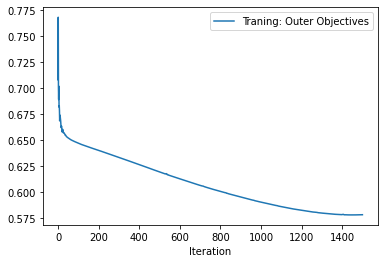

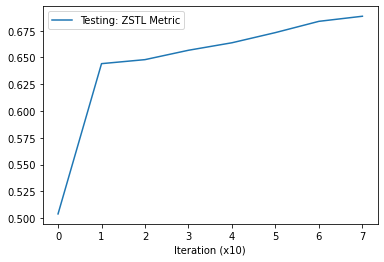

mean acc  tensor(0.6873, device='cuda:0', dtype=torch.float64)
142 8
8
142
50
knowledge base size  torch.Size([312, 8]) torch.Size([2049, 8])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 8])
init mean test metric 0.49825; align loss 0.002054080832749605
1/1500 o_loss 0.7029997601273602; m train metric 0.5037500000000004; m test metric 0.50225; align loss  0.0005162905436009169
200/1500 o_loss 0.6435840252720352; m train metric 0.6521428571428571; m test metric 0.63175; align loss  0.0005314744194038212
400/1500 o_loss 0.628994654102384; m train metric 0.6717857142857143; m test metric 0.6405000000000001; align loss  0.0008618230931460857
600/1500 o_loss 0.6157983632791522; m train metric 0.6816964285714288; m test metric 0.6455; align loss  0.0016133995959535241
800/1500 o_loss 0.6001653580726789; m train metric 0.7042857142857142; m test metric 0.6520000000000001; align loss  0.0027743596583604813
10

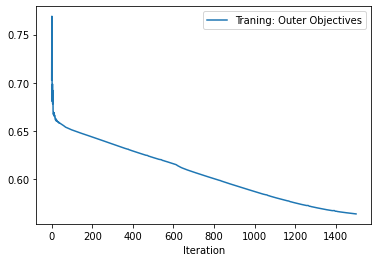

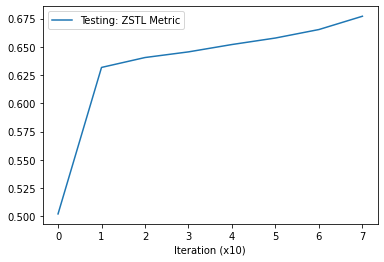

mean acc  tensor(0.6783, device='cuda:0', dtype=torch.float64)
k=8, mean_acc=0.6908000000000001
139 11
11
139
50
knowledge base size  torch.Size([312, 11]) torch.Size([2049, 11])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 11])
init mean test metric 0.49675000000000014; align loss 0.0020645027980208397
1/1500 o_loss 0.7050128664675658; m train metric 0.5035971223021584; m test metric 0.5037499999999998; align loss  0.000191116938367486
200/1500 o_loss 0.6367916374629793; m train metric 0.687320143884892; m test metric 0.62225; align loss  0.0002020977553911507
400/1500 o_loss 0.6196090413505386; m train metric 0.7108812949640286; m test metric 0.6312500000000001; align loss  0.0003407513431739062
600/1500 o_loss 0.6006609305870056; m train metric 0.72976618705036; m test metric 0.643; align loss  0.0006881000590510666
800/1500 o_loss 0.5823109584069884; m train metric 0.7447841726618707; m test metri

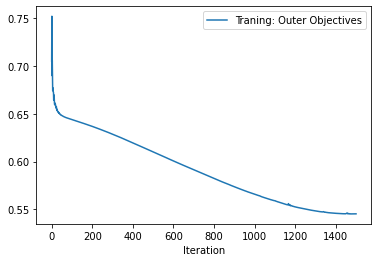

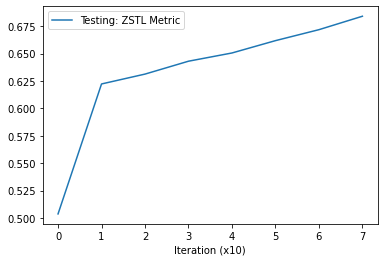

mean acc  tensor(0.6817, device='cuda:0', dtype=torch.float64)
139 11
11
139
50
knowledge base size  torch.Size([312, 11]) torch.Size([2049, 11])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 11])
init mean test metric 0.49650000000000005; align loss 0.002161544281989336
1/1500 o_loss 0.7081256880183712; m train metric 0.5034172661870505; m test metric 0.5035; align loss  0.00026956177316606045
200/1500 o_loss 0.6396558451275308; m train metric 0.6827338129496405; m test metric 0.6265; align loss  0.00018970586825162172
400/1500 o_loss 0.6204003973632863; m train metric 0.7061151079136687; m test metric 0.6367499999999999; align loss  0.0003770527255255729
600/1500 o_loss 0.6026994024500546; m train metric 0.7204136690647484; m test metric 0.63625; align loss  0.0009060637094080448
800/1500 o_loss 0.5867955620457559; m train metric 0.7360611510791369; m test metric 0.6407499999999999; align loss  0.002

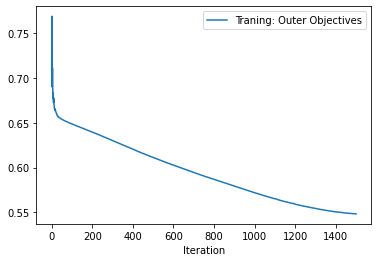

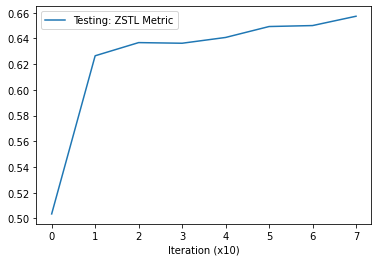

mean acc  tensor(0.6578, device='cuda:0', dtype=torch.float64)
139 11
11
139
50
knowledge base size  torch.Size([312, 11]) torch.Size([2049, 11])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 11])
init mean test metric 0.49500000000000016; align loss 0.0023486153222620487
1/1500 o_loss 0.7090941509960568; m train metric 0.5031474820143886; m test metric 0.5042499999999999; align loss  0.00036369520239531994
200/1500 o_loss 0.6411580611648467; m train metric 0.6737410071942448; m test metric 0.62775; align loss  0.00026172329671680927
400/1500 o_loss 0.625770477497642; m train metric 0.6910071942446044; m test metric 0.6402499999999999; align loss  0.00036502163857221603
600/1500 o_loss 0.6048982905713077; m train metric 0.726798561151079; m test metric 0.6565000000000002; align loss  0.0006912208627909422
800/1500 o_loss 0.5875559350887729; m train metric 0.7413669064748202; m test metric 0.67000000000

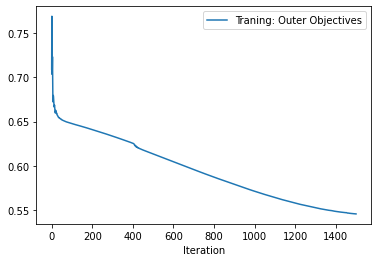

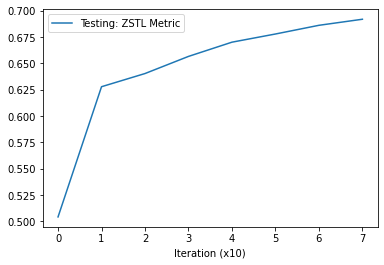

mean acc  tensor(0.6985, device='cuda:0', dtype=torch.float64)
139 11
11
139
50
knowledge base size  torch.Size([312, 11]) torch.Size([2049, 11])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 11])
init mean test metric 0.4927500000000002; align loss 0.0020908729638904333
1/1500 o_loss 0.7084121155701645; m train metric 0.5035971223021583; m test metric 0.5039999999999999; align loss  0.0002645765198394656
200/1500 o_loss 0.6310717569012531; m train metric 0.6858812949640288; m test metric 0.65075; align loss  0.00022362859454005957
400/1500 o_loss 0.6110255751497508; m train metric 0.71591726618705; m test metric 0.6647499999999998; align loss  0.0004691409703809768
600/1500 o_loss 0.5878431505972533; m train metric 0.739928057553957; m test metric 0.68475; align loss  0.0011557044927030802
800/1500 o_loss 0.5677126595087135; m train metric 0.7492805755395688; m test metric 0.6862500000000002; align lo

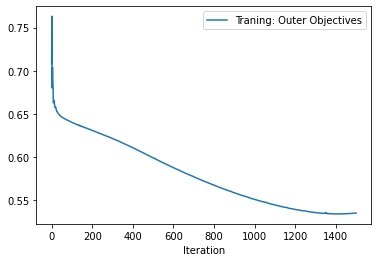

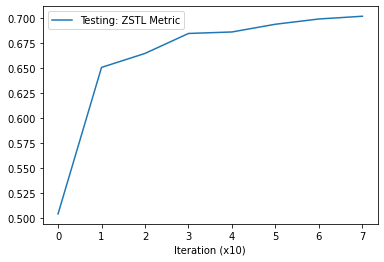

mean acc  tensor(0.6977, device='cuda:0', dtype=torch.float64)
139 11
11
139
50
knowledge base size  torch.Size([312, 11]) torch.Size([2049, 11])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 11])
init mean test metric 0.4965000000000001; align loss 0.002243124647065997
1/1500 o_loss 0.7078058452868043; m train metric 0.5033273381294966; m test metric 0.5034999999999998; align loss  0.00030266796238720417
200/1500 o_loss 0.6425012658490873; m train metric 0.6849820143884894; m test metric 0.6455; align loss  0.00019782257732003927
400/1500 o_loss 0.6286966288261276; m train metric 0.7044064748201437; m test metric 0.65325; align loss  0.0003029395593330264
600/1500 o_loss 0.6140499062578214; m train metric 0.7240107913669065; m test metric 0.6697499999999998; align loss  0.0005438579246401787
800/1500 o_loss 0.6000099483954473; m train metric 0.7352517985611511; m test metric 0.6739999999999999; align 

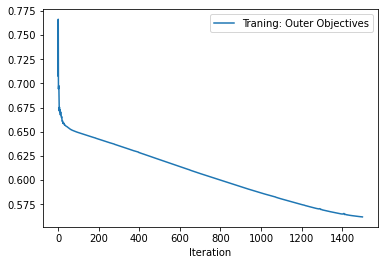

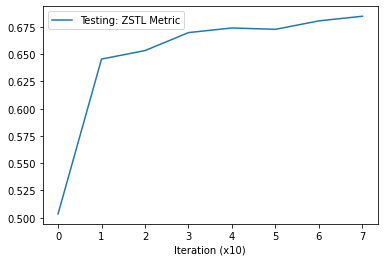

mean acc  tensor(0.6885, device='cuda:0', dtype=torch.float64)
k=11, mean_acc=0.68485
136 14
14
136
50
knowledge base size  torch.Size([312, 14]) torch.Size([2049, 14])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 14])
init mean test metric 0.49525000000000013; align loss 0.002397318137809634
1/1500 o_loss 0.708081924740006; m train metric 0.5034007352941178; m test metric 0.5039999999999999; align loss  0.00010504480451345444
200/1500 o_loss 0.6286512353484902; m train metric 0.7011029411764705; m test metric 0.6677500000000002; align loss  0.00011542136780917645
400/1500 o_loss 0.60618674383937; m train metric 0.7271139705882353; m test metric 0.6772500000000001; align loss  0.0002533055667299777
600/1500 o_loss 0.58355296855135; m train metric 0.7456801470588237; m test metric 0.6954999999999998; align loss  0.0006025291513651609
800/1500 o_loss 0.5639238409451482; m train metric 0.7622242647058824

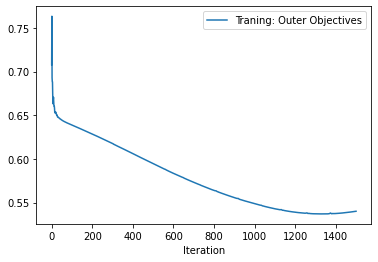

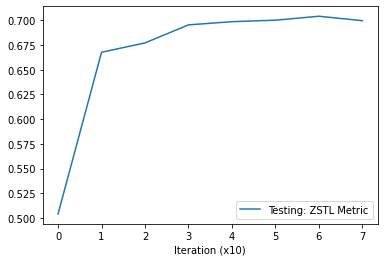

mean acc  tensor(0.6925, device='cuda:0', dtype=torch.float64)
136 14
14
136
50
knowledge base size  torch.Size([312, 14]) torch.Size([2049, 14])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 14])
init mean test metric 0.49875; align loss 0.0024627242237329483
1/1500 o_loss 0.7026559325921184; m train metric 0.504044117647059; m test metric 0.5017499999999999; align loss  0.000132410554215312
200/1500 o_loss 0.6217695126474342; m train metric 0.7227941176470585; m test metric 0.627; align loss  0.00011738028842955828
400/1500 o_loss 0.6007806043661035; m train metric 0.7416360294117648; m test metric 0.6299999999999999; align loss  0.00018779694801196456
600/1500 o_loss 0.5786560456378057; m train metric 0.7604779411764703; m test metric 0.63975; align loss  0.0003952270490117371
800/1500 o_loss 0.5583383732283598; m train metric 0.7767463235294116; m test metric 0.6515; align loss  0.00083407037891447

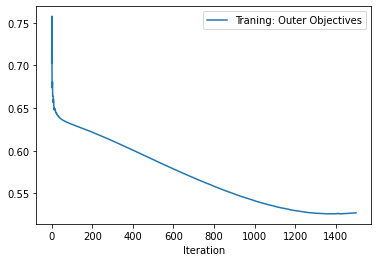

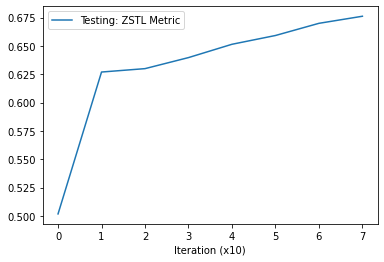

mean acc  tensor(0.6805, device='cuda:0', dtype=torch.float64)
136 14
14
136
50
knowledge base size  torch.Size([312, 14]) torch.Size([2049, 14])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 14])
init mean test metric 0.49750000000000005; align loss 0.002457514638081193
1/1500 o_loss 0.7045324930702063; m train metric 0.5039522058823531; m test metric 0.5025; align loss  0.00014656130224466324
200/1500 o_loss 0.6475466864375288; m train metric 0.6904411764705884; m test metric 0.6365; align loss  9.049498476088047e-05
400/1500 o_loss 0.6278192308621809; m train metric 0.717922794117647; m test metric 0.6502500000000001; align loss  0.00012459448771551251
600/1500 o_loss 0.6076003681210911; m train metric 0.7331801470588237; m test metric 0.6542500000000001; align loss  0.0002755255554802716
800/1500 o_loss 0.590302833054653; m train metric 0.743841911764706; m test metric 0.6512500000000001; align los

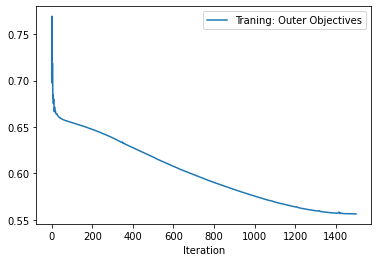

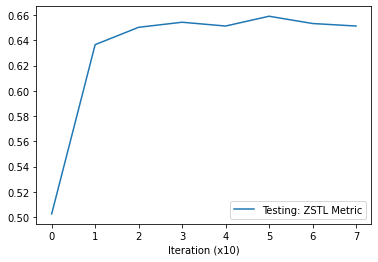

mean acc  tensor(0.6477, device='cuda:0', dtype=torch.float64)
136 14
14
136
50
knowledge base size  torch.Size([312, 14]) torch.Size([2049, 14])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 14])
init mean test metric 0.49575; align loss 0.002656693570315838
1/1500 o_loss 0.7095088239841382; m train metric 0.5034007352941179; m test metric 0.50425; align loss  0.00016271485947072506
200/1500 o_loss 0.6384738740401671; m train metric 0.7030330882352943; m test metric 0.6772500000000002; align loss  0.00011656025890260935
400/1500 o_loss 0.6225568345227444; m train metric 0.7166360294117646; m test metric 0.689; align loss  0.00020641135051846504
600/1500 o_loss 0.6086775134043658; m train metric 0.7265624999999999; m test metric 0.6874999999999999; align loss  0.00040099199395626783
800/1500 o_loss 0.5960574490155148; m train metric 0.7364889705882351; m test metric 0.6909999999999996; align loss  0.00

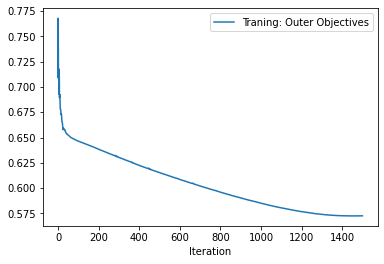

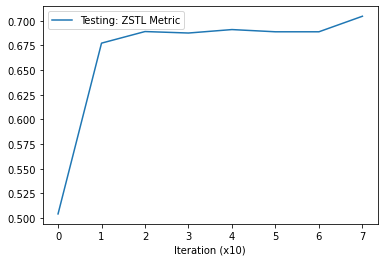

mean acc  tensor(0.7075, device='cuda:0', dtype=torch.float64)
136 14
14
136
50
knowledge base size  torch.Size([312, 14]) torch.Size([2049, 14])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 14])
init mean test metric 0.49625000000000014; align loss 0.002398628508672118
1/1500 o_loss 0.7065749317133689; m train metric 0.5031250000000002; m test metric 0.5037499999999998; align loss  0.00017640902660787106
200/1500 o_loss 0.6407618745887542; m train metric 0.6836397058823531; m test metric 0.6475; align loss  0.0001150377793237567
400/1500 o_loss 0.615850933978115; m train metric 0.7102022058823525; m test metric 0.6525; align loss  0.00021335078054107726
600/1500 o_loss 0.5919645490563091; m train metric 0.737408088235294; m test metric 0.6502500000000002; align loss  0.0005302050849422812
800/1500 o_loss 0.5721851024941048; m train metric 0.7533088235294116; m test metric 0.6579999999999999; align lo

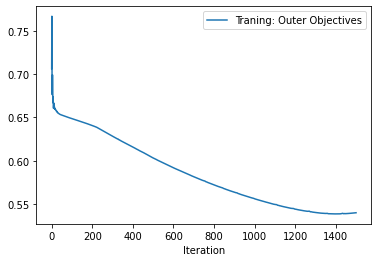

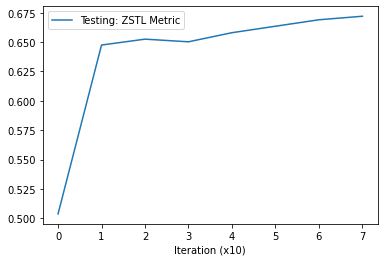

mean acc  tensor(0.6772, device='cuda:0', dtype=torch.float64)
k=14, mean_acc=0.6811
133 17
17
133
50
knowledge base size  torch.Size([312, 17]) torch.Size([2049, 17])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 17])
init mean test metric 0.4972500000000001; align loss 0.003000443335622549
1/1500 o_loss 0.7071963183011131; m train metric 0.5037593984962407; m test metric 0.5027499999999999; align loss  0.00013237656094133854
200/1500 o_loss 0.6394450665430579; m train metric 0.6703007518796992; m test metric 0.629; align loss  7.071113213896751e-05
400/1500 o_loss 0.6210774906326253; m train metric 0.6994360902255639; m test metric 0.6425; align loss  9.159964974969625e-05
600/1500 o_loss 0.6028043439216155; m train metric 0.7156015037593985; m test metric 0.6545000000000001; align loss  0.00016717781545594335
800/1500 o_loss 0.5858987211389817; m train metric 0.730451127819549; m test metric 0.66224

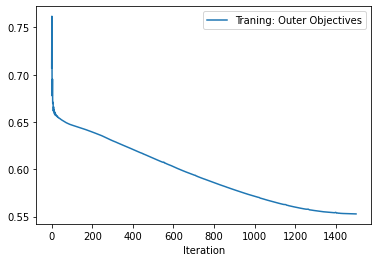

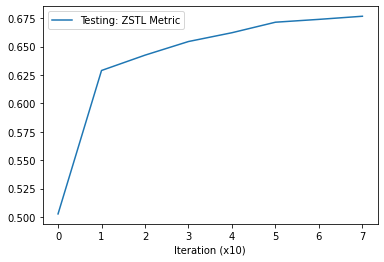

mean acc  tensor(0.6800, device='cuda:0', dtype=torch.float64)
133 17
17
133
50
knowledge base size  torch.Size([312, 17]) torch.Size([2049, 17])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 17])
init mean test metric 0.4960000000000001; align loss 0.0031883856281638145
1/1500 o_loss 0.7061001840152574; m train metric 0.5032894736842107; m test metric 0.5039999999999999; align loss  0.00013155397027730942
200/1500 o_loss 0.6316890855638408; m train metric 0.7058270676691728; m test metric 0.63475; align loss  7.731933146715164e-05
400/1500 o_loss 0.6149680801296145; m train metric 0.7193609022556389; m test metric 0.6445000000000001; align loss  9.587034583091736e-05
600/1500 o_loss 0.5960689854083401; m train metric 0.7337406015037592; m test metric 0.6452500000000001; align loss  0.00021002741414122283
800/1500 o_loss 0.578559601271553; m train metric 0.7434210526315789; m test metric 0.650999999999

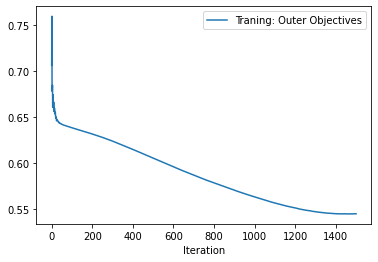

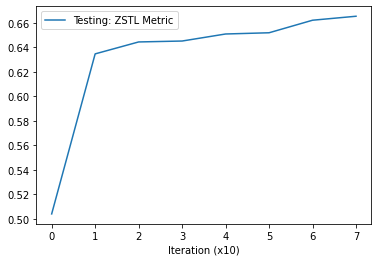

mean acc  tensor(0.6615, device='cuda:0', dtype=torch.float64)
133 17
17
133
50
knowledge base size  torch.Size([312, 17]) torch.Size([2049, 17])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 17])
init mean test metric 0.4965000000000001; align loss 0.0030016666278243065
1/1500 o_loss 0.7038458695432129; m train metric 0.5032894736842107; m test metric 0.5034999999999998; align loss  7.624737918376923e-05
200/1500 o_loss 0.6236027576382923; m train metric 0.7070488721804512; m test metric 0.6302500000000001; align loss  6.481027230620384e-05
400/1500 o_loss 0.5969043164391462; m train metric 0.7391917293233082; m test metric 0.6402499999999999; align loss  0.00013127934653311968
600/1500 o_loss 0.5703249448504215; m train metric 0.7618421052631577; m test metric 0.6489999999999999; align loss  0.0003513388801366091
800/1500 o_loss 0.5462189724045644; m train metric 0.7783834586466168; m test metric 0.6

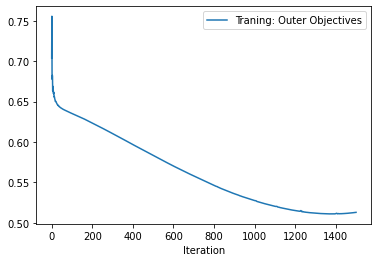

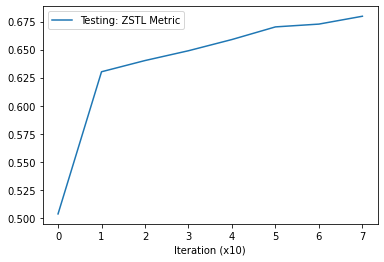

mean acc  tensor(0.6890, device='cuda:0', dtype=torch.float64)
133 17
17
133
50
knowledge base size  torch.Size([312, 17]) torch.Size([2049, 17])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 17])
init mean test metric 0.498; align loss 0.0030660051852464676
1/1500 o_loss 0.7032519475893027; m train metric 0.5029135338345866; m test metric 0.5037499999999999; align loss  8.49585048854351e-05
200/1500 o_loss 0.6327596326232572; m train metric 0.7144736842105265; m test metric 0.64425; align loss  5.774653982371092e-05
400/1500 o_loss 0.6072316893194346; m train metric 0.7467105263157894; m test metric 0.67425; align loss  9.487010538578033e-05
600/1500 o_loss 0.5794203763484562; m train metric 0.7689849624060144; m test metric 0.6927500000000001; align loss  0.00024296867195516825
800/1500 o_loss 0.5555258197955003; m train metric 0.782424812030075; m test metric 0.69725; align loss  0.00060133892111480

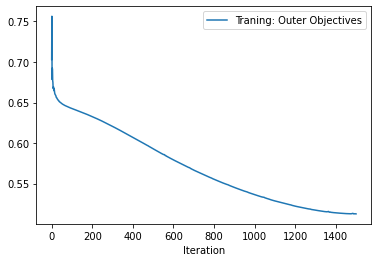

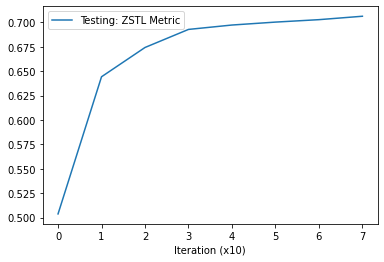

mean acc  tensor(0.7110, device='cuda:0', dtype=torch.float64)
133 17
17
133
50
knowledge base size  torch.Size([312, 17]) torch.Size([2049, 17])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 17])
init mean test metric 0.49700000000000016; align loss 0.003218009602278471
1/1500 o_loss 0.7100763867969827; m train metric 0.5032894736842107; m test metric 0.5029999999999998; align loss  0.00016941619105637074
200/1500 o_loss 0.6396373283132014; m train metric 0.6833646616541356; m test metric 0.61375; align loss  9.591586422175169e-05
400/1500 o_loss 0.6147549221208108; m train metric 0.7077067669172933; m test metric 0.645; align loss  0.00015181675553321838
600/1500 o_loss 0.59487495525509; m train metric 0.7234962406015037; m test metric 0.6657500000000002; align loss  0.00034653066541068256
800/1500 o_loss 0.5791281826367; m train metric 0.7334586466165416; m test metric 0.6707500000000003; align loss

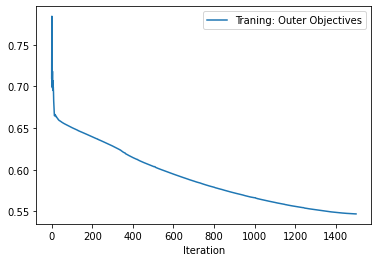

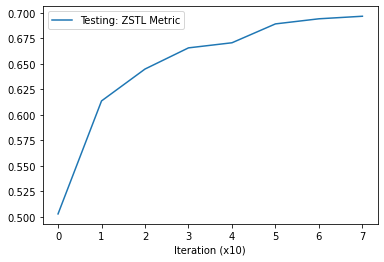

mean acc  tensor(0.6907, device='cuda:0', dtype=torch.float64)
k=17, mean_acc=0.68645
130 20
20
130
50
knowledge base size  torch.Size([312, 20]) torch.Size([2049, 20])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 20])
init mean test metric 0.49625000000000014; align loss 0.003592098830267787
1/1500 o_loss 0.7044411273350796; m train metric 0.5035576923076924; m test metric 0.5037499999999998; align loss  9.545264765620232e-05
200/1500 o_loss 0.6270637777598145; m train metric 0.7030769230769228; m test metric 0.66675; align loss  7.169379387050867e-05
400/1500 o_loss 0.6022443850273983; m train metric 0.7311538461538463; m test metric 0.6755000000000001; align loss  9.144993964582682e-05
600/1500 o_loss 0.5772589246455867; m train metric 0.7532692307692308; m test metric 0.68; align loss  0.00018910630024038255
800/1500 o_loss 0.5562798457220197; m train metric 0.768653846153846; m test metric 0.6849

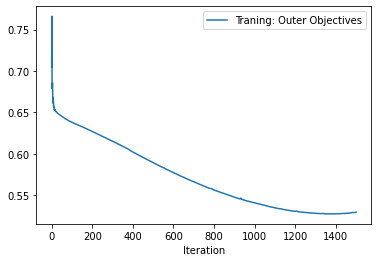

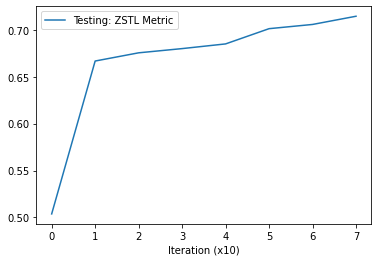

mean acc  tensor(0.7180, device='cuda:0', dtype=torch.float64)
130 20
20
130
50
knowledge base size  torch.Size([312, 20]) torch.Size([2049, 20])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 20])
init mean test metric 0.49774999999999997; align loss 0.003229626454412937
1/1500 o_loss 0.7050189920557807; m train metric 0.503846153846154; m test metric 0.50225; align loss  7.266364991664886e-05
200/1500 o_loss 0.6251807637261944; m train metric 0.7240384615384617; m test metric 0.6970000000000002; align loss  5.779892671853304e-05
400/1500 o_loss 0.5980400252585801; m train metric 0.7472115384615385; m test metric 0.6940000000000002; align loss  0.00011031166650354862
600/1500 o_loss 0.5730812303865186; m train metric 0.7695192307692309; m test metric 0.6910000000000001; align loss  0.00027116748970001936
800/1500 o_loss 0.5524607444182038; m train metric 0.780961538461538; m test metric 0.6982499999999

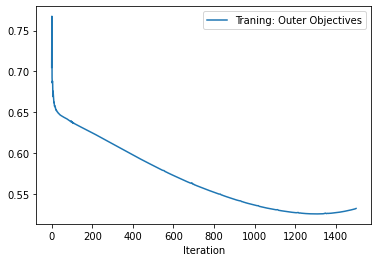

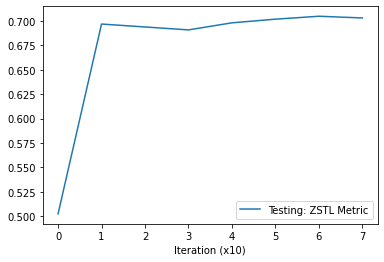

mean acc  tensor(0.6943, device='cuda:0', dtype=torch.float64)
130 20
20
130
50
knowledge base size  torch.Size([312, 20]) torch.Size([2049, 20])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 20])
init mean test metric 0.49700000000000005; align loss 0.0034922470804303885
1/1500 o_loss 0.7055871991619754; m train metric 0.5033653846153848; m test metric 0.503; align loss  7.777707651257515e-05
200/1500 o_loss 0.6290122468812535; m train metric 0.7049999999999997; m test metric 0.6794999999999999; align loss  5.980848800390959e-05
400/1500 o_loss 0.6109358396202039; m train metric 0.723653846153846; m test metric 0.68475; align loss  7.22843105904758e-05
600/1500 o_loss 0.5904643040723526; m train metric 0.7414423076923081; m test metric 0.6930000000000001; align loss  0.00012754672206938267
800/1500 o_loss 0.5702295911426728; m train metric 0.759326923076923; m test metric 0.696; align loss  0.00026347

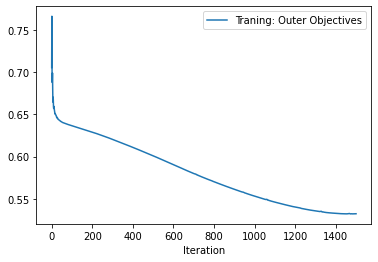

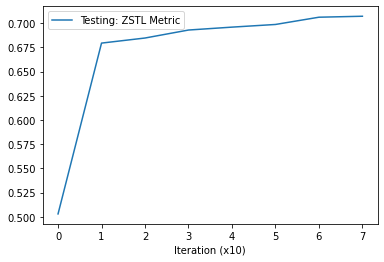

mean acc  tensor(0.7065, device='cuda:0', dtype=torch.float64)
130 20
20
130
50
knowledge base size  torch.Size([312, 20]) torch.Size([2049, 20])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 20])
init mean test metric 0.49625000000000014; align loss 0.003453034907579422
1/1500 o_loss 0.7074503788796183; m train metric 0.5032692307692309; m test metric 0.5037499999999998; align loss  7.56317749619484e-05
200/1500 o_loss 0.6191337745744162; m train metric 0.7237499999999997; m test metric 0.6807499999999999; align loss  5.448854062706232e-05
400/1500 o_loss 0.5970446850101535; m train metric 0.7452884615384614; m test metric 0.6829999999999999; align loss  0.00011861888924613595
600/1500 o_loss 0.5761519527492616; m train metric 0.7625961538461539; m test metric 0.68275; align loss  0.00031841557938605547
800/1500 o_loss 0.5580394242531979; m train metric 0.7758653846153845; m test metric 0.68025; align

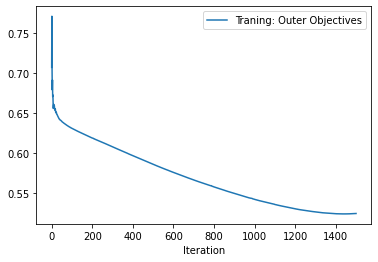

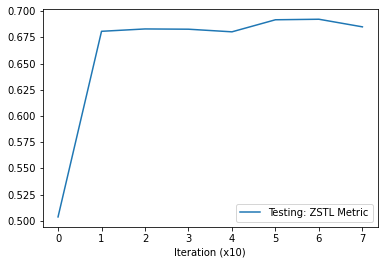

mean acc  tensor(0.6813, device='cuda:0', dtype=torch.float64)
130 20
20
130
50
knowledge base size  torch.Size([312, 20]) torch.Size([2049, 20])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 20])
init mean test metric 0.49725; align loss 0.003346600802615285
1/1500 o_loss 0.7050275056085621; m train metric 0.5035576923076925; m test metric 0.50225; align loss  7.75663647800684e-05
200/1500 o_loss 0.6312806269153953; m train metric 0.678173076923077; m test metric 0.64; align loss  6.28387788310647e-05
400/1500 o_loss 0.6115963810481705; m train metric 0.7049038461538465; m test metric 0.6552500000000001; align loss  9.567540837451816e-05
600/1500 o_loss 0.5901984100265859; m train metric 0.7337499999999999; m test metric 0.6677500000000001; align loss  0.00019554610480554402
800/1500 o_loss 0.5695935529943269; m train metric 0.7576923076923079; m test metric 0.6880000000000002; align loss  0.000411135

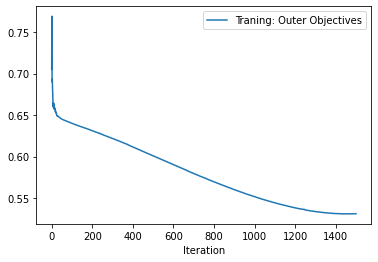

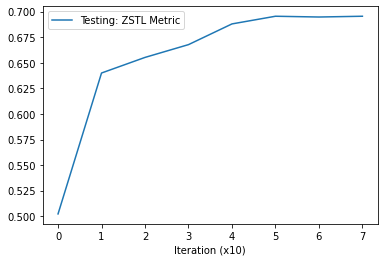

mean acc  tensor(0.6937, device='cuda:0', dtype=torch.float64)
k=20, mean_acc=0.69875
127 23
23
127
50
knowledge base size  torch.Size([312, 23]) torch.Size([2049, 23])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 23])
init mean test metric 0.49750000000000005; align loss 0.0038319649174809456
1/1500 o_loss 0.707020799334227; m train metric 0.5038385826771655; m test metric 0.5025; align loss  6.849458441138268e-05
200/1500 o_loss 0.6189762659583563; m train metric 0.7453740157480311; m test metric 0.6875; align loss  3.625103272497654e-05
400/1500 o_loss 0.5933080332273045; m train metric 0.7670275590551183; m test metric 0.69225; align loss  5.456962389871478e-05
600/1500 o_loss 0.5688623437753284; m train metric 0.7818897637795277; m test metric 0.7012499999999998; align loss  0.00012297506327740848
800/1500 o_loss 0.5481170213590633; m train metric 0.7916338582677162; m test metric 0.7044999999999

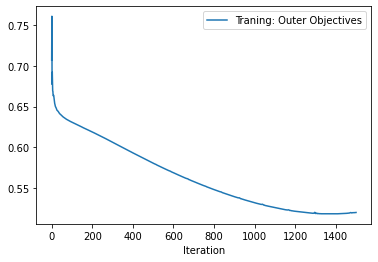

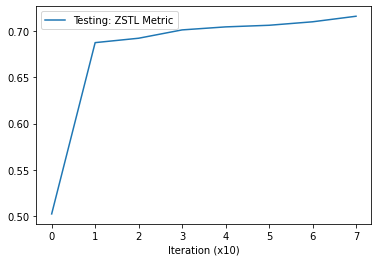

mean acc  tensor(0.7155, device='cuda:0', dtype=torch.float64)
127 23
23
127
50
knowledge base size  torch.Size([312, 23]) torch.Size([2049, 23])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 23])
init mean test metric 0.4960000000000001; align loss 0.004097527824342251
1/1500 o_loss 0.7035861613382915; m train metric 0.502952755905512; m test metric 0.5039999999999999; align loss  6.935186684131622e-05
200/1500 o_loss 0.6213173600533376; m train metric 0.7339566929133859; m test metric 0.6862499999999998; align loss  4.192069172859192e-05
400/1500 o_loss 0.5959319122186972; m train metric 0.7606299212598425; m test metric 0.6892499999999999; align loss  5.4076139349490404e-05
600/1500 o_loss 0.5693364689038611; m train metric 0.7854330708661423; m test metric 0.70325; align loss  0.00011593804811127484
800/1500 o_loss 0.5454901698463428; m train metric 0.8038385826771651; m test metric 0.69875; align 

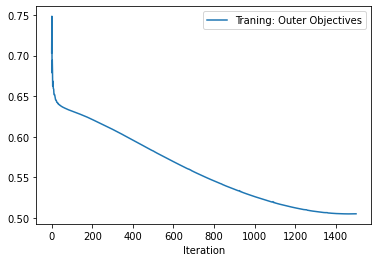

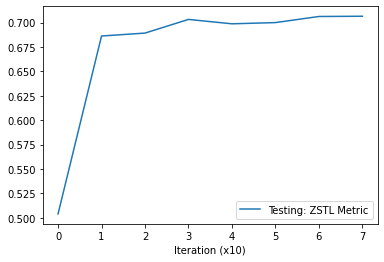

mean acc  tensor(0.7045, device='cuda:0', dtype=torch.float64)
127 23
23
127
50
knowledge base size  torch.Size([312, 23]) torch.Size([2049, 23])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 23])
init mean test metric 0.4960000000000001; align loss 0.0037285760045051575
1/1500 o_loss 0.710711889529938; m train metric 0.5036417322834646; m test metric 0.5034999999999998; align loss  6.357161328196526e-05
200/1500 o_loss 0.6174550375160505; m train metric 0.7335629921259843; m test metric 0.6787499999999999; align loss  4.3492414988577366e-05
400/1500 o_loss 0.5904779267996022; m train metric 0.7556102362204722; m test metric 0.6802499999999999; align loss  7.522478699684143e-05
600/1500 o_loss 0.5630119926860835; m train metric 0.7757874015748033; m test metric 0.6832500000000001; align loss  0.00018597921007312834
800/1500 o_loss 0.5398728594616583; m train metric 0.7935039370078741; m test metric 0.6

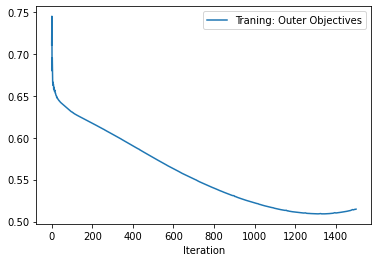

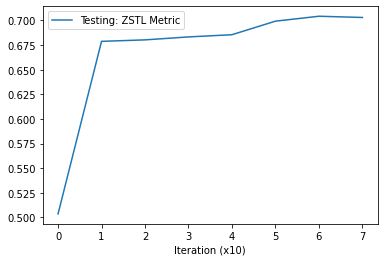

mean acc  tensor(0.7070, device='cuda:0', dtype=torch.float64)
127 23
23
127
50
knowledge base size  torch.Size([312, 23]) torch.Size([2049, 23])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 23])
init mean test metric 0.4972500000000001; align loss 0.003835082985460758
1/1500 o_loss 0.7086507841673364; m train metric 0.503444881889764; m test metric 0.5027499999999999; align loss  6.117066368460655e-05
200/1500 o_loss 0.6114563290469759; m train metric 0.7275590551181099; m test metric 0.6917500000000001; align loss  4.678196273744106e-05
400/1500 o_loss 0.5811720515498672; m train metric 0.7568897637795275; m test metric 0.6920000000000001; align loss  0.00010096060577780008
600/1500 o_loss 0.5581479865918303; m train metric 0.7768700787401575; m test metric 0.70225; align loss  0.0002491323684807867
800/1500 o_loss 0.5402706291922551; m train metric 0.7913385826771655; m test metric 0.70274999999999

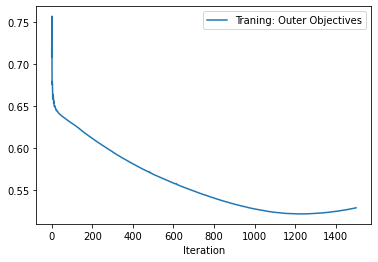

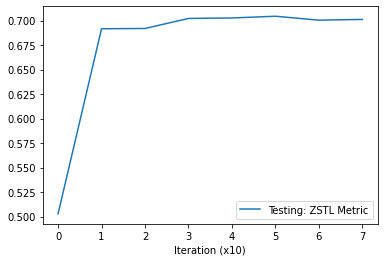

mean acc  tensor(0.7017, device='cuda:0', dtype=torch.float64)
127 23
23
127
50
knowledge base size  torch.Size([312, 23]) torch.Size([2049, 23])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 23])
init mean test metric 0.49675; align loss 0.004160506185144186
1/1500 o_loss 0.7048106058244044; m train metric 0.5027559055118112; m test metric 0.5035; align loss  7.434841245412827e-05
200/1500 o_loss 0.6232550479343352; m train metric 0.7114173228346459; m test metric 0.6705000000000001; align loss  4.83817420899868e-05
400/1500 o_loss 0.5992214978071237; m train metric 0.7332677165354328; m test metric 0.68; align loss  6.687024142593145e-05
600/1500 o_loss 0.5748572255059431; m train metric 0.757775590551181; m test metric 0.6934999999999998; align loss  0.00014739620382897556
800/1500 o_loss 0.5544845309240494; m train metric 0.7752952755905516; m test metric 0.6935000000000002; align loss  0.000329414

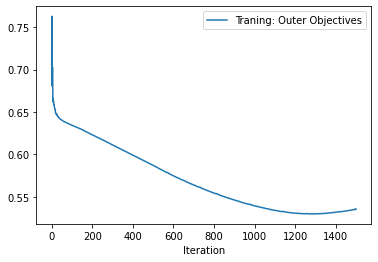

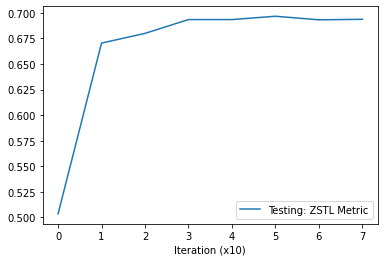

mean acc  tensor(0.7097, device='cuda:0', dtype=torch.float64)
k=23, mean_acc=0.7077
124 26
26
124
50
knowledge base size  torch.Size([312, 26]) torch.Size([2049, 26])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 26])
init mean test metric 0.4962500000000001; align loss 0.004498606082051992
1/1500 o_loss 0.7073897989016146; m train metric 0.5037298387096775; m test metric 0.5037499999999999; align loss  6.216904148459435e-05
200/1500 o_loss 0.6212939225858257; m train metric 0.7259072580645161; m test metric 0.675; align loss  3.1152041628956795e-05
400/1500 o_loss 0.5923811858670125; m train metric 0.7527217741935485; m test metric 0.6799999999999998; align loss  5.5738724768161774e-05
600/1500 o_loss 0.5660899333175151; m train metric 0.7729838709677417; m test metric 0.6890000000000001; align loss  0.00014842470409348607
800/1500 o_loss 0.5442372803846675; m train metric 0.787399193548387; m test m

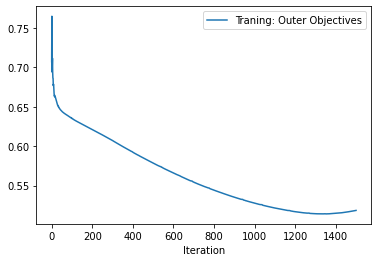

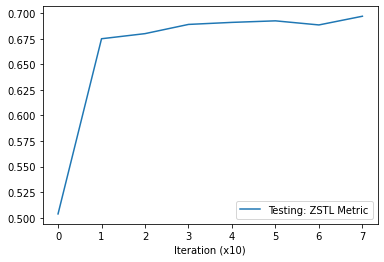

mean acc  tensor(0.6997, device='cuda:0', dtype=torch.float64)
124 26
26
124
50
knowledge base size  torch.Size([312, 26]) torch.Size([2049, 26])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 26])
init mean test metric 0.49625; align loss 0.004382662940770388
1/1500 o_loss 0.7083468588008995; m train metric 0.5030241935483872; m test metric 0.5037499999999999; align loss  5.8191828429698944e-05
200/1500 o_loss 0.6383290601924302; m train metric 0.703225806451613; m test metric 0.6520000000000001; align loss  3.0219554901123047e-05
400/1500 o_loss 0.6074912685360159; m train metric 0.7471774193548388; m test metric 0.6607500000000002; align loss  3.8986559957265854e-05
600/1500 o_loss 0.5815812115437321; m train metric 0.7662298387096774; m test metric 0.6787499999999999; align loss  8.430040907114744e-05
800/1500 o_loss 0.5600277676637615; m train metric 0.7780241935483869; m test metric 0.687999999999

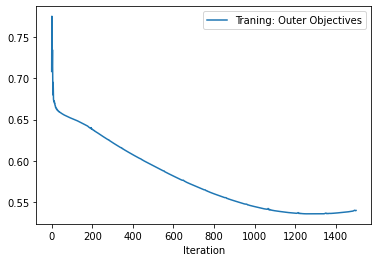

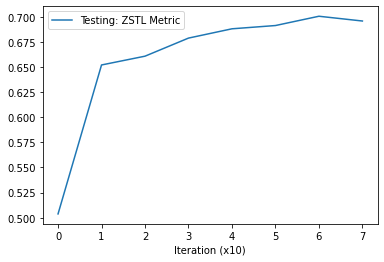

mean acc  tensor(0.7045, device='cuda:0', dtype=torch.float64)
124 26
26
124
50
knowledge base size  torch.Size([312, 26]) torch.Size([2049, 26])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 26])
init mean test metric 0.4970000000000001; align loss 0.004764565732330084
1/1500 o_loss 0.7046089581394147; m train metric 0.503326612903226; m test metric 0.5029999999999999; align loss  5.7837460190057755e-05
200/1500 o_loss 0.6082372454806201; m train metric 0.749798387096774; m test metric 0.70875; align loss  3.5961391404271126e-05
400/1500 o_loss 0.5805636758825952; m train metric 0.7740927419354837; m test metric 0.7242499999999998; align loss  6.083236075937748e-05
600/1500 o_loss 0.5551513518927799; m train metric 0.7899193548387099; m test metric 0.72925; align loss  0.00015365611761808395
800/1500 o_loss 0.5335988803285985; m train metric 0.799395161290323; m test metric 0.7382500000000001; align l

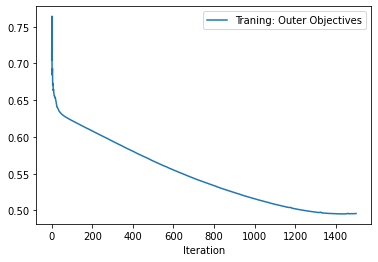

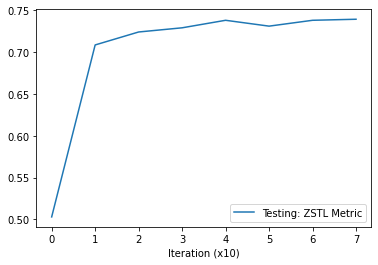

mean acc  tensor(0.7433, device='cuda:0', dtype=torch.float64)
124 26
26
124
50
knowledge base size  torch.Size([312, 26]) torch.Size([2049, 26])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 26])
init mean test metric 0.49750000000000005; align loss 0.004223439376801252
1/1500 o_loss 0.7092461121689168; m train metric 0.5038306451612905; m test metric 0.5025; align loss  4.9085356295108795e-05
200/1500 o_loss 0.6360176520932826; m train metric 0.7117943548387096; m test metric 0.6822500000000001; align loss  3.1125498935580254e-05
400/1500 o_loss 0.6090033007485252; m train metric 0.7406250000000002; m test metric 0.70075; align loss  4.182232078164816e-05
600/1500 o_loss 0.5823650344485236; m train metric 0.7622983870967737; m test metric 0.7132499999999997; align loss  9.26172942854464e-05
800/1500 o_loss 0.5596123183626801; m train metric 0.7800403225806448; m test metric 0.7190000000000001; align 

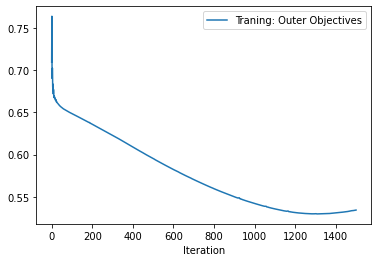

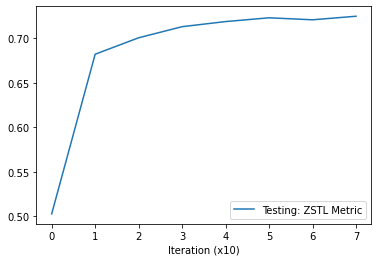

mean acc  tensor(0.7230, device='cuda:0', dtype=torch.float64)
124 26
26
124
50
knowledge base size  torch.Size([312, 26]) torch.Size([2049, 26])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 26])
init mean test metric 0.49650000000000005; align loss 0.0044984654523432255
1/1500 o_loss 0.7061775839857517; m train metric 0.5032258064516131; m test metric 0.5035; align loss  6.159581243991852e-05
200/1500 o_loss 0.6252283071047596; m train metric 0.733568548387097; m test metric 0.6812499999999999; align loss  3.090547397732735e-05
400/1500 o_loss 0.5969831313367092; m train metric 0.7710685483870965; m test metric 0.6990000000000001; align loss  3.910530358552933e-05
600/1500 o_loss 0.5670514241341621; m train metric 0.7944556451612903; m test metric 0.71125; align loss  9.025839972309768e-05
800/1500 o_loss 0.5407052407221448; m train metric 0.8112903225806449; m test metric 0.7185000000000001; align l

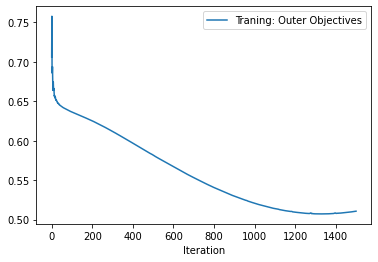

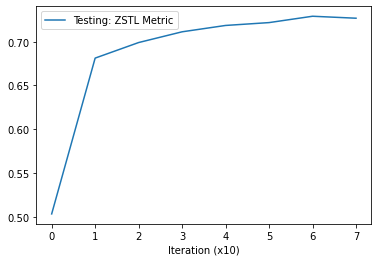

mean acc  tensor(0.7308, device='cuda:0', dtype=torch.float64)
k=26, mean_acc=0.72025
121 29
29
121
50
knowledge base size  torch.Size([312, 29]) torch.Size([2049, 29])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 29])
init mean test metric 0.4972500000000001; align loss 0.005146438721567392
1/1500 o_loss 0.7097521340666909; m train metric 0.5038223140495869; m test metric 0.5027499999999999; align loss  5.7957135140895844e-05
200/1500 o_loss 0.6277412359895231; m train metric 0.7153925619834712; m test metric 0.6537499999999998; align loss  3.32612544298172e-05
400/1500 o_loss 0.6030672065151687; m train metric 0.7397727272727271; m test metric 0.6627499999999997; align loss  4.112790338695049e-05
600/1500 o_loss 0.5806800662655353; m train metric 0.7579545454545457; m test metric 0.6757500000000001; align loss  7.888145046308637e-05
800/1500 o_loss 0.5611986084802707; m train metric 0.77551652892562

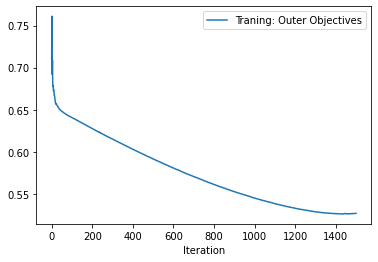

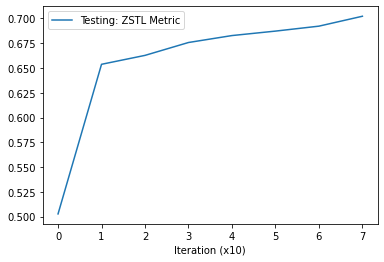

mean acc  tensor(0.7040, device='cuda:0', dtype=torch.float64)
121 29
29
121
50
knowledge base size  torch.Size([312, 29]) torch.Size([2049, 29])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 29])
init mean test metric 0.49625; align loss 0.005159728229045868
1/1500 o_loss 0.7049575526082565; m train metric 0.503512396694215; m test metric 0.50375; align loss  5.1375944167375565e-05
200/1500 o_loss 0.6256082432059772; m train metric 0.7295454545454544; m test metric 0.68975; align loss  2.9699644073843956e-05
400/1500 o_loss 0.6015828552440363; m train metric 0.747417355371901; m test metric 0.6875000000000003; align loss  3.896607086062431e-05
600/1500 o_loss 0.5758638245030498; m train metric 0.7645661157024795; m test metric 0.6999999999999998; align loss  8.77505517564714e-05
800/1500 o_loss 0.5527791955954711; m train metric 0.7775826446280995; m test metric 0.7115; align loss  0.00021673085575457

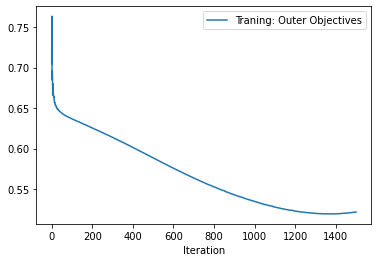

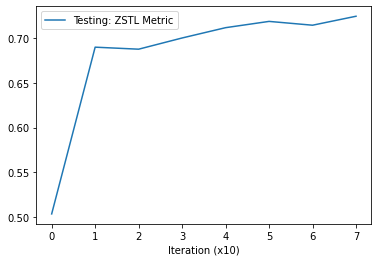

mean acc  tensor(0.7263, device='cuda:0', dtype=torch.float64)
121 29
29
121
50
knowledge base size  torch.Size([312, 29]) torch.Size([2049, 29])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 29])
init mean test metric 0.49500000000000016; align loss 0.005108424928039312
1/1500 o_loss 0.7083424291465709; m train metric 0.5028925619834712; m test metric 0.5049999999999999; align loss  5.459832027554512e-05
200/1500 o_loss 0.6219040626344418; m train metric 0.7289256198347112; m test metric 0.665; align loss  3.079511225223541e-05
400/1500 o_loss 0.5943836203453031; m train metric 0.7629132231404956; m test metric 0.6720000000000002; align loss  3.48077155649662e-05
600/1500 o_loss 0.5654198062367553; m train metric 0.7844008264462812; m test metric 0.669; align loss  7.350416854023933e-05
800/1500 o_loss 0.5396080993939468; m train metric 0.8045454545454545; m test metric 0.6679999999999998; align loss 

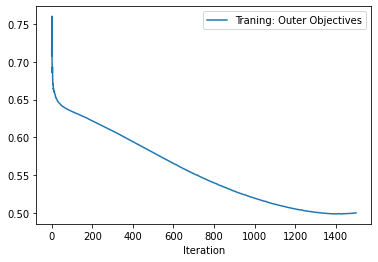

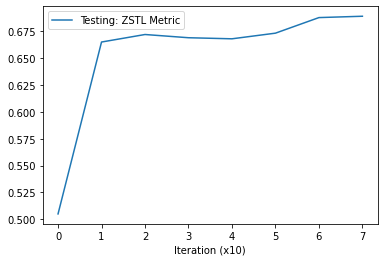

mean acc  tensor(0.6935, device='cuda:0', dtype=torch.float64)
121 29
29
121
50
knowledge base size  torch.Size([312, 29]) torch.Size([2049, 29])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 29])
init mean test metric 0.49750000000000016; align loss 0.005026881117373705
1/1500 o_loss 0.7100249803317172; m train metric 0.5044421487603308; m test metric 0.5024999999999998; align loss  5.953153595328331e-05
200/1500 o_loss 0.6112499280317018; m train metric 0.737190082644628; m test metric 0.6880000000000002; align loss  3.34989745169878e-05
400/1500 o_loss 0.5844246991178836; m train metric 0.766322314049587; m test metric 0.6905000000000001; align loss  3.9097038097679615e-05
600/1500 o_loss 0.5579563545040047; m train metric 0.7892561983471071; m test metric 0.6970000000000001; align loss  8.077593520283699e-05
800/1500 o_loss 0.534590975993336; m train metric 0.80650826446281; m test metric 0.6984999

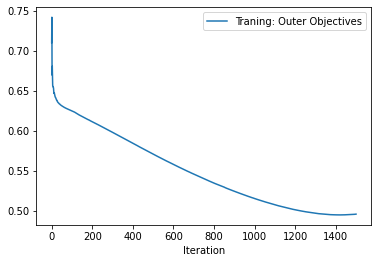

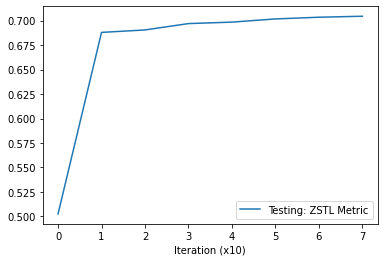

mean acc  tensor(0.7005, device='cuda:0', dtype=torch.float64)
121 29
29
121
50
knowledge base size  torch.Size([312, 29]) torch.Size([2049, 29])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 29])
init mean test metric 0.4967500000000002; align loss 0.004688688553869724
1/1500 o_loss 0.7050512090887228; m train metric 0.5033057851239671; m test metric 0.5032499999999999; align loss  5.347421392798424e-05
200/1500 o_loss 0.6184527258550333; m train metric 0.7458677685950416; m test metric 0.711; align loss  3.0324561521410942e-05
400/1500 o_loss 0.5905561602274187; m train metric 0.7670454545454545; m test metric 0.7195; align loss  4.262744914740324e-05
600/1500 o_loss 0.5623828347941692; m train metric 0.7923553719008263; m test metric 0.7225000000000003; align loss  0.00010345573537051678
800/1500 o_loss 0.5368290164484835; m train metric 0.8086776859504132; m test metric 0.7284999999999999; align lo

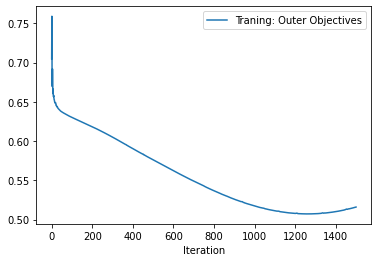

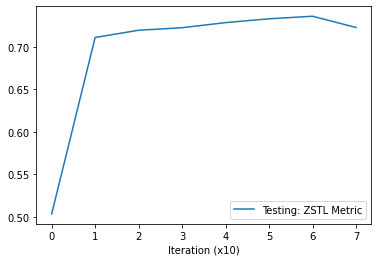

mean acc  tensor(0.7240, device='cuda:0', dtype=torch.float64)
k=29, mean_acc=0.7096499999999999
118 32
32
118
50
knowledge base size  torch.Size([312, 32]) torch.Size([2049, 32])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 32])
init mean test metric 0.4975; align loss 0.0052976468577980995
1/1500 o_loss 0.7093906671961107; m train metric 0.5043432203389834; m test metric 0.5025; align loss  5.6103337556123734e-05
200/1500 o_loss 0.6313603471459474; m train metric 0.7003177966101698; m test metric 0.65775; align loss  3.353878855705261e-05
400/1500 o_loss 0.6009837231772431; m train metric 0.7423728813559322; m test metric 0.6705; align loss  3.432051744312048e-05
600/1500 o_loss 0.574598219648193; m train metric 0.7606991525423729; m test metric 0.68175; align loss  6.552145350724459e-05
800/1500 o_loss 0.5521256988473489; m train metric 0.7779661016949154; m test metric 0.68975; align loss  0.00014

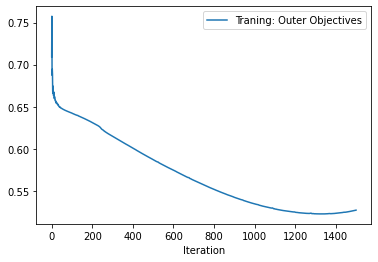

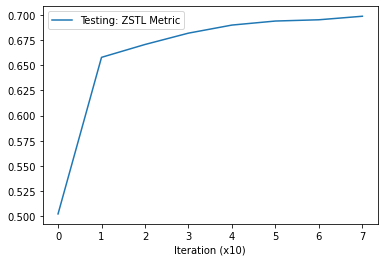

mean acc  tensor(0.6947, device='cuda:0', dtype=torch.float64)
118 32
32
118
50
knowledge base size  torch.Size([312, 32]) torch.Size([2049, 32])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 32])
init mean test metric 0.4960000000000001; align loss 0.0056578670628368855
1/1500 o_loss 0.7078781690117035; m train metric 0.5031779661016951; m test metric 0.5039999999999999; align loss  4.7116540372371674e-05
200/1500 o_loss 0.607800535305198; m train metric 0.7471398305084744; m test metric 0.6877500000000001; align loss  2.6196008548140526e-05
400/1500 o_loss 0.5737010339764341; m train metric 0.78135593220339; m test metric 0.6964999999999999; align loss  3.9138831198215485e-05
600/1500 o_loss 0.5434072093280443; m train metric 0.8042372881355933; m test metric 0.69575; align loss  9.215797763317823e-05
800/1500 o_loss 0.5179791305119456; m train metric 0.8230932203389835; m test metric 0.6995000000000

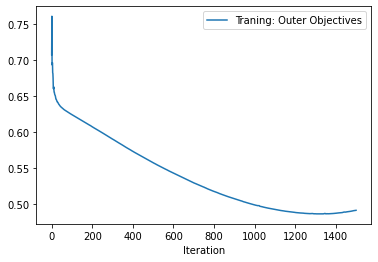

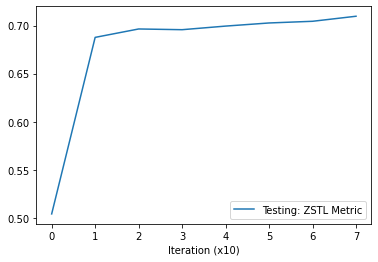

mean acc  tensor(0.7180, device='cuda:0', dtype=torch.float64)
118 32
32
118
50
knowledge base size  torch.Size([312, 32]) torch.Size([2049, 32])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 32])
init mean test metric 0.4965000000000001; align loss 0.005711617413908243
1/1500 o_loss 0.7055465784634195; m train metric 0.5036016949152543; m test metric 0.5037499999999999; align loss  5.0648581236600876e-05
200/1500 o_loss 0.6051798879910829; m train metric 0.757521186440678; m test metric 0.6919999999999998; align loss  3.0387192964553833e-05
400/1500 o_loss 0.5714644281177829; m train metric 0.7862288135593218; m test metric 0.69325; align loss  4.960549995303154e-05
600/1500 o_loss 0.5418539807689771; m train metric 0.8059322033898307; m test metric 0.6949999999999998; align loss  0.00012497330317273736
800/1500 o_loss 0.516954683477722; m train metric 0.8238347457627117; m test metric 0.6955; align l

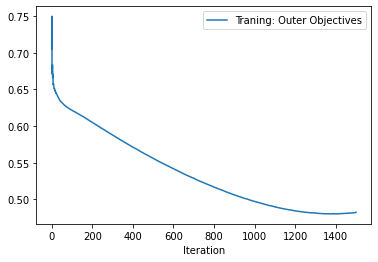

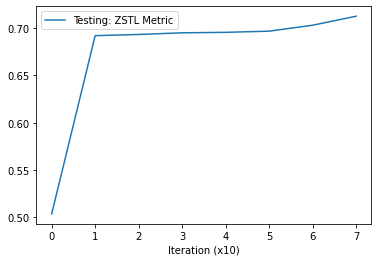

mean acc  tensor(0.7300, device='cuda:0', dtype=torch.float64)
118 32
32
118
50
knowledge base size  torch.Size([312, 32]) torch.Size([2049, 32])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 32])
init mean test metric 0.4972500000000001; align loss 0.005650551989674568
1/1500 o_loss 0.7059497555117991; m train metric 0.5033898305084746; m test metric 0.5027499999999999; align loss  4.857312887907028e-05
200/1500 o_loss 0.6192208388188886; m train metric 0.731885593220339; m test metric 0.6995000000000001; align loss  2.4698907509446144e-05
400/1500 o_loss 0.5832329264573627; m train metric 0.773728813559322; m test metric 0.7077500000000002; align loss  3.168894909322262e-05
600/1500 o_loss 0.5498572528614836; m train metric 0.7985169491525426; m test metric 0.7117500000000001; align loss  7.649057079106569e-05
800/1500 o_loss 0.5221713994929599; m train metric 0.8189618644067793; m test metric 0.7127

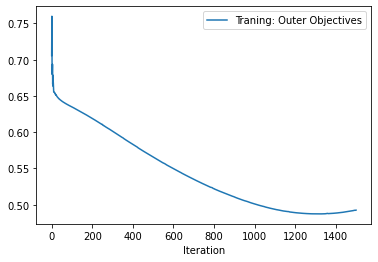

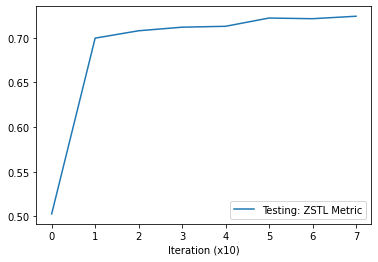

mean acc  tensor(0.7263, device='cuda:0', dtype=torch.float64)
118 32
32
118
50
knowledge base size  torch.Size([312, 32]) torch.Size([2049, 32])
test  torch.Size([312, 50]) torch.Size([2049, 50]) torch.Size([50, 80, 2049]) torch.Size([50, 80, 1])
weight_kb  torch.Size([2049, 32])
init mean test metric 0.4957500000000001; align loss 0.005527809727936983
1/1500 o_loss 0.706961558689758; m train metric 0.503177966101695; m test metric 0.5042499999999999; align loss  4.7551002353429794e-05
200/1500 o_loss 0.6092457732706631; m train metric 0.7510593220338985; m test metric 0.6779999999999999; align loss  2.7001602575182915e-05
400/1500 o_loss 0.5785551311732349; m train metric 0.7794491525423728; m test metric 0.6912500000000001; align loss  4.1049555875360966e-05
600/1500 o_loss 0.5474811750148438; m train metric 0.8018008474576269; m test metric 0.6984999999999999; align loss  0.00011148053454235196
800/1500 o_loss 0.5204405155253865; m train metric 0.8189618644067803; m test metric 0.7

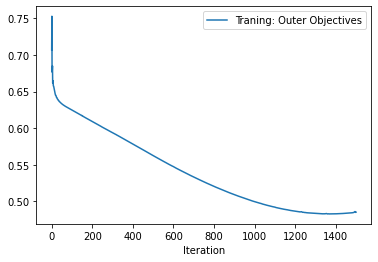

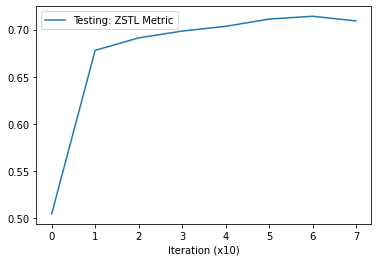

mean acc  tensor(0.7020, device='cuda:0', dtype=torch.float64)
k=32, mean_acc=0.7142000000000001


In [ ]:
kEffect_result = []

for k in K:
  temp = 0
  for r in range(5):
    trainSize = totSize - k - test_size1
    print(trainSize, k)
    support_loader, train_loader, test_loader = genSplits(dataset, trainSize, test_size1, k, len(dataset), train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    print('knowledge base size ', support_a.shape, support_w.shape)
    ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
    ZSTL_model.train(train_loader, test_loader, max_iter=1500)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    temp += utils.toNumpy(mean_acc.cpu())

  kEffect_result.append(temp/5)
  print('k={}, mean_acc={}'.format(k, kEffect_result[-1]))
  

In [ ]:
#new kEffect_result (5 runs each)
print(kEffect_result)

[0.58155, 0.6635, 0.6908000000000001, 0.68485, 0.6811, 0.68645, 0.69875, 0.7077, 0.72025, 0.7096499999999999, 0.7142000000000001]


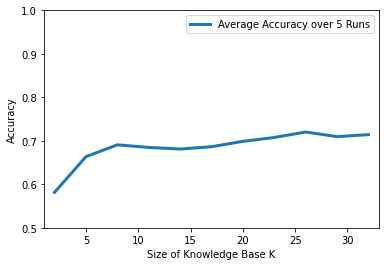

In [ ]:
plt.plot(K,kEffect_result, linewidth=3, label='Average Accuracy over 5 Runs')
plt.xlabel('Size of Knowledge Base K')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.xlim([1,33])
plt.legend()
plt.savefig('K_effect2.png')

In [ ]:
#old kEffect_result (5 runs each)
print(kEffect_result)

[0.58155, 0.6635, 0.6908000000000001, 0.68485, 0.6811, 0.68645, 0.69875, 0.7077, 0.72025, 0.7096499999999999, 0.7142000000000001]
